In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
from pymc.Matplot import plot as pmplot


sns.set()


In [11]:
dick = pd.read_pickle('country_data.pkl')

### 2020-04-14
# Germany has a negative dead_inc 2020-04-11, which makes poisson obs fail. 
# patching that number here

ger = dick['Germany']
ger.at['2020-04-11','dead_inc'] = 0
dick['Germany'] = ger
ger

,confirmed,factor,inc,deceased,dead_factor,dead_inc,pct_dead,conf_over_dead,dead_conf_ratio
2020-01-24,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2020-01-25,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN
2020-01-26,0,NaN,0.0,0,NaN,0.0,NaN,NaN,NaN
2020-01-27,1,NaN,1.0,0,NaN,0.0,0.000000,NaN,NaN
2020-01-28,4,4.000000,3.0,0,NaN,0.0,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020-05-04,166152,1.002946,488.0,6993,1.018497,127.0,4.208797,23.759760,1.015506
2020-05-05,167007,1.005146,855.0,6993,1.000000,0.0,4.187250,23.882025,0.994880
2020-05-06,168162,1.006916,1155.0,7275,1.040326,282.0,4.326185,23.115052,1.033181
2020-05-07,169430,1.007540,1268.0,7392,1.016082,117.0,4.362864,22.920725,1.008478


In [12]:
esp = dick['Spain']
esp.at['2020-04-24','inc'] = 0 
dick['Spain'] = esp


In [13]:


def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})

def process_country(country_name):
    
    country = dick[country_name]
    country_population = country_populations.loc[country_name,'population']
    country['conf_per_M'] = country['confirmed'] / (country_population / 1e6)
    country['dead_per_M'] = country['deceased'] / (country_population / 1e6)
    
    return country



In [14]:
r_prior = pm.rlognormal(0.27,1/0.05**2,100000)
f_prior = pm.rbeta(5,200,100000)

In [15]:
### ASSUMPTIONS ###
### 1) nr of dead inc is a function of nr of confirmed
### D = true mortality rate (f) x confirmed total (C) x hidden factor infected (r)
### 2) D = f * C
### 3) D = C * r * f 

def inference(df,C,D,country_name):
    
    f_alpha = pm.Uniform('f_alpha',1,100)
    f_beta = pm.Uniform ('f_beta',50,500)
    
    #r_mu = pm.Uniform('r_mu',0.2,0.6) #high autocorrelation for Italy
    r_mu = pm.Uniform('r_mu',0.05,0.6)

    r_sigma = pm.Uniform('r_sigma',0,0.2)
    
    r = pm.Lognormal('r',r_mu, 1 / r_sigma ** 2)
    
    #r = pm.Lognormal('r',0.27,1/0.05**2)
    
    f = pm.Beta('f',f_alpha,f_beta)
    #m = pm.Uniform ('m',-2,2)

    @pm.deterministic()
    def prediction(C=C,r=r,f=f):
        return C * r * f 

    obs = pm.Poisson('obs',prediction, observed=True,value=D)

    model = pm.Model([f,r,prediction,obs])
    try:
        map_ = pm.MAP(model)
        map_.fit()
        
    except:
        print ('cant fit {}'.format(country_name))

    mcmc = pm.MCMC(model)

    mcmc.sample(200000,60000,4)
    
    r_mu_post = mcmc.trace('r_mu')[:]
    r_sigma_post = mcmc.trace('r_sigma')[:]
    r_post = mcmc.trace('r')[:]
    f_post = mcmc.trace('f')[:]
    f_alpha_post = mcmc.trace('f_alpha')[:]
    f_beta_post = mcmc.trace('f_beta')[:]
    
    
    pmplot(r_mu_post,'r_mu_post')
    pmplot(r_sigma_post,'r_sigma_post')
    pmplot(f_alpha_post,'f_alpha_post')
    pmplot(f_beta_post,'f_beta_post')
    pmplot(r_post,'r_post')
    pmplot(f_post,'f_post')

    prediction_post = mcmc.trace('prediction')[:,0]

    result = pd.DataFrame({'r_post':r_post,
                          'f_post':f_post,
                          'prediction_post':prediction_post})

    print ()
    print ('++++++++++++++ {} ++++++++++++++++'.format(country_name))
    print (result.describe())
    print()
    
    plt.figure(figsize=(18,12))
    plt.hist(r_prior,color='r',label='r prior',alpha=0.5,histtype='stepfilled',density=True)
    plt.hist(result.r_post,color='g',label='r posterior',alpha=0.7,histtype='stepfilled',density=True)
    plt.legend(loc='upper left')

    plt.figure(figsize=(18,12))
    plt.hist(f_prior,color='r',label='f prior',alpha=0.5,histtype='stepfilled',density=True)
    plt.hist(result.f_post,color='g',label='f posterior',alpha=0.7,histtype='stepfilled',density=True)
    
    plt.legend(loc='upper left')
    
    return result



In [16]:

def create_posterior_samples(result):
    N = 10000
    f_samples = np.random.choice(result.f_post,replace=True,size=N)
    r_samples = np.random.choice(result.r_post,replace=True,size=N)

    death_samples = np.array([pm.rpoisson(C[i] * r_samples * f_samples,N) for i in range(len(C))])
    conf_samples = np.array([pm.rpoisson(C[i] * r_samples,N) for i in range(len(C))])

    death_sample_df = pd.DataFrame(death_samples,index=range(len(death_samples)))
    death_sample_df.index.name='day'
    death_sample_df.columns.name='sample_nr'
    
    conf_sample_df = pd.DataFrame(conf_samples,index=range(len(conf_samples)))
    conf_sample_df.index.name='day'
    conf_sample_df.columns.name='sample_nr'
    
    
    return death_sample_df,conf_sample_df

In [17]:

def plot(result,df,sample_df,country_name,param='dead_inc',title_patch='deaths per day'):
    
    if title_patch == 'deaths per day':
        col = 5 # dead_inc
    else:
        col = 0 # confirmed
    
    samples_89 = np.percentile(sample_df.iloc[-1,:],[5.5,94.5])
    samples_daily_mean = sample_df.mean(axis=1)
    
    plt.figure(figsize=(18,12))
    title_postfix = r' posterior mean growth factor $\mu$: {:.2f} posterior mean mortality rate $\mu$: {:.4f}'.format(
    result.r_post.mean(),result.f_post.mean())
    
    title_postfix_2 = ' Last Day Sample 89% CI: {:.2f} , {:.2f} : Last Day Actual: {}'.format(
        int(samples_89[0]),int(samples_89[1]),df.iloc[-1,col])

    sns.violinplot(data=sample_df.T,inner='quartile',scale='count',palette=['orange'])
    
    plt.plot(range(len(df)),samples_daily_mean,color='crimson',ls='dashed',label='death samples daily mean ')

    plt.title('Bayesian Posterior Expected number of {} {}, after the day CONFIRMED hit {} \n'.format(
       title_patch, country_name,limit) + title_postfix + '\n' + title_postfix_2)

    plt.ylabel('Expected number of {}'.format(title_patch))
    plt.xlabel('Day after number of confirmed hit {}'.format(limit))
    plt.scatter(range(len(df)),df[param],color='crimson',label='actual data')
    plt.legend(loc='upper left')
    
    plt.savefig('{}_violinplot_{}.jpg'.format(country_name,param),format='jpg')


++++++++++++++++++++++ Sweden +++++++++++++++++++++++
            confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-05-04      22721  1.018103  404.0      2769     1.033595      90.0   
2020-05-05      23216  1.021786  495.0      2854     1.030697      85.0   
2020-05-06      23918  1.030238  702.0      2941     1.030484      87.0   
2020-05-07      24623  1.029476  705.0      3040     1.033662      99.0   
2020-05-08      25265  1.026073  642.0      3175     1.044408     135.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-05-04  12.186964        8.205489         1.015216  2249.767681   
2020-05-05  12.293246        8.134548         1.008721  2298.781149   
2020-05-06  12.296179        8.132608         1.000239  2368.291158   
2020-05-07  12.346180        8.099671         1.004066  2438.098218   
2020-05-08  12.566792        7.957480         1.017869  2501.667201   

            dead_per_M  
2020-05-04  274.178368  
2020-05-05  282.5

sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
15          471   277   423   422   487   298   617   365   465   367  ...   
16          615   412   504   528   596   391   773   463   644   471  ...   
17          807   484   625   745   713   537   949   529   777   583  ...   
18          948   596   806   833   924   644  1146   697   942   713  ...   
19          851   534   730   726   821   598  1052   619   855   615  ...   
20          481   278   430   438   461   333   564   344   483   351  ...   
21          581   365   484   527   552   395   745   428   532   450  ...   
22          566   366   462   461   558   407   669   423   537   434  ...   
23          774   513   624   627   661   515   899   496   723   533  ...   
24         1209   706   934   959   990   799  1378   738  1094   824  ...   
25         1057   691   922   978   980   753  1317   783  1060 

 [-----------------100%-----------------] 200000 of 200000 complete in 244.5 secPlotting r_mu_post
Plotting r_sigma_post
Plotting f_alpha_post
Plotting f_beta_post
Plotting r_post
Plotting f_post

++++++++++++++ US ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.494108      0.041662        19.363559
std        0.272568      0.007905         0.069873
min        0.900690      0.027769        19.081583
25%        1.264912      0.035566        19.315718
50%        1.511404      0.039781        19.363592
75%        1.690874      0.047556        19.410631
max        2.164413      0.067215        19.683736

sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
19         1066   736  1381  1565  1741  1375  1221  1015  1128  1187  ...   
20         1406   933  1787  2014  2123  1743  1492  1294  148


++++++++++++++++++++++ Germany +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-05-04     166152  1.002946   488.0      6993     1.018497     127.0   
2020-05-05     167007  1.005146   855.0      6993     1.000000       0.0   
2020-05-06     168162  1.006916  1155.0      7275     1.040326     282.0   
2020-05-07     169430  1.007540  1268.0      7392     1.016082     117.0   
2020-05-08     170588  1.006835  1158.0      7510     1.015963     118.0   

            pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  dead_per_M  
2020-05-04  4.208797       23.759760         1.015506  1983.100771   83.464681  
2020-05-05  4.187250       23.882025         0.994880  1993.305591   83.464681  
2020-05-06  4.326185       23.115052         1.033181  2007.091049   86.830481  
2020-05-07  4.362864       22.920725         1.008478  2022.225214   88.226930  
2020-05-08  4.402420       22.714780         1.009067  2036.046478   89.635315  
 

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Germany ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.370853      0.033533        10.704959
std        0.253251      0.006260         0.123372
min        0.760749      0.020477        10.182251
25%        1.156235      0.028413        10.620838
50%        1.356527      0.032723        10.704992
75%        1.563310      0.038410        10.788226
max        2.150135      0.056929        11.243051

sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
22          232   215   164   378   179   209   414   260   233   194  ...   
23          276   224   165   352   181   203   409   266   231   233  ...   
24          379   256   206   451   250   293   543   310   320   273  ...   
25          384   254   253   490   277   264   566   377   319   287  ...   
26          370   3

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


day
22    220.0192
23    226.2827
24    278.8171
25    318.5046
26    292.3299
27    226.7661
28    185.3696
29    149.5344
30    197.2059
31    259.1672
32    224.6260
33    183.5608
34    125.6953
35    135.3727
36    102.0245
37     59.1693
38    156.2980
39    135.3466
40    169.8283
41     89.4842
42     84.7555
43     86.4922
44     56.2798
45    108.4518
46    113.8180
47     86.1302
48     69.6194
49     57.7814
50     45.4837
51     52.9726
52     74.8973
53     67.4814
54     49.1276
55     40.9649
56     32.0820
57     22.4571
58     39.2735
59     53.0988
60     58.2419
61     53.2879
dtype: float64
Last day summary stats
conf sample_df.tail(40)
sample_nr  0     1     2      3     4     5      6      7     8      9     \
day                                                                         
22         5330  6224  5418   8388  6675  5505   9310   7032  6558   7456   
23         5479  6483  5587   8735  6808  5844   9911   7491  6695   7547   
24         6795  8033  687

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ Belgium +++++++++++++++++++++++
            confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-05-04      50267  1.007234  361.0      7924     1.010199      80.0   
2020-05-05      50509  1.004814  242.0      8016     1.011610      92.0   
2020-05-06      50781  1.005385  272.0      8339     1.040294     323.0   
2020-05-07      51420  1.012583  639.0      8415     1.009114      76.0   
2020-05-08      52011  1.011494  591.0      8521     1.012597     106.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-05-04  15.763821        6.343640         1.002944  4337.242031   
2020-05-05  15.870439        6.301023         1.006763  4358.122779   
2020-05-06  16.421496        6.089579         1.034722  4381.592050   
2020-05-07  16.365228        6.110517         0.996573  4436.727579   
2020-05-08  16.383073        6.103861         1.001090  4487.721473   

            dead_per_M  
2020-05-04  683.715079  
2020-05-05  691.

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Belgium ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.356382      0.127834        28.657542
std        0.272653      0.025705         0.311920
min        0.726754      0.069285        27.420270
25%        1.146552      0.107709        28.445050
50%        1.322064      0.125990        28.654486
75%        1.547096      0.145315        28.866795
max        2.394002      0.233263        29.962337

sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
14          199   189   139   127   190   162   146   276   171   152  ...   
15          148   165   112   126   148   125   133   181   152   113  ...   
16          226   200   145   152   193   167   174   285   194   156  ...   
17          217   293   180   163   213   217   189   305   236   196  ...   
18          246   2

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0]


++++++++++++++++++++++ Italy +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-05-04     211938  1.005795  1221.0     29079     1.006751     195.0   
2020-05-05     213013  1.005072  1075.0     29315     1.008116     236.0   
2020-05-06     214457  1.006779  1444.0     29684     1.012587     369.0   
2020-05-07     215858  1.006533  1401.0     29958     1.009231     274.0   
2020-05-08     217185  1.006148  1327.0     30201     1.008111     243.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-05-04  13.720522        7.288352         1.000951  3505.319208   
2020-05-05  13.762071        7.266348         1.003028  3523.099021   
2020-05-06  13.841469        7.224666         1.005769  3546.981859   
2020-05-07  13.878568        7.205354         1.002680  3570.153505   
2020-05-08  13.905656        7.191318         1.001952  3592.101238   

            dead_per_M  
2020-05-04  480.948094  
2020-05-05  

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Italy ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.298115      0.110042        33.489020
std        0.207059      0.016260         0.191255
min        0.889754      0.067247        32.759035
25%        1.137499      0.099302        33.360286
50%        1.258329      0.110952        33.489729
75%        1.405039      0.122672        33.615407
max        2.090660      0.157246        34.291718



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
30          473   532   518   555   539   800   663   654   632   573  ...   
31          441   559   423   572   591   857   665   649   663   571  ...   
32          526   627   547   699   683   959   740   799   759   690  ...   
33          552   649   556   651   610   940   738   806   722   687  ...   
34          538   620   544   661   631   874   763   811   749   653  ...   
35          569   638   495   634   638   983   773   809   822   709  ...   
36          532   561   497   598   557   902   689   708   694   639  ...   
37          432   466   412   486   521   714   594   583   565   527  ...   
38          364   396   376   403   443   590   495   519   494   476  ...   
39          472   546   447   545   489   761   637   648   670   525  ...   
40          500   629   495   609   551   844   687 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ United Kingdom +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-05-04     191832  1.021241  3990.0     28809     1.010133     289.0   
2020-05-05     196243  1.022994  4411.0     29501     1.024020     692.0   
2020-05-06     202359  1.031165  6116.0     30150     1.021999     649.0   
2020-05-07     207977  1.027763  5618.0     30689     1.017877     539.0   
2020-05-08     212629  1.022368  4652.0     31316     1.020431     627.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-05-04  15.017828        6.658752         0.989123  2825.795730   
2020-05-05  15.032893        6.652080         1.001003  2890.772298   
2020-05-06  14.899263        6.711741         0.991111  2980.864497   
2020-05-07  14.755959        6.776923         0.990382  3063.620869   
2020-05-08  14.728000        6.789788         0.998105  3132.147505   

            dead_per_M  
2020-05-04  424.373145  
202

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ United Kingdom ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.426328      0.107027        50.544071
std        0.254918      0.019419         0.286006
min        0.914453      0.068430        49.394843
25%        1.210800      0.090593        50.351904
50%        1.425436      0.103710        50.543809
75%        1.631012      0.122097        50.736273
max        2.168289      0.162492        51.722930



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
16          297   427   380   523   348   574   378   419   419   432  ...   
17          353   488   448   563   360   593   430   496   436   474  ...   
18          467   735   644   852   526   839   596   679   630   729  ...   
19          452   684   617   850   544   808   584   683   638   740  ...   
20          484   764   667   800   552   841   649   725   630   792  ...   
21          420   595   549   754   455   764   513   606   526   594  ...   
22          578   925   845  1107   782  1148   851   915   841   963  ...   
23          397   587   566   783   494   801   560   553   497   640  ...   
24          416   569   490   724   434   667   502   518   548   603  ...   
25          622   866   835  1015   742  1076   805   870   761   886  ...   
26          420   676   657   784   496   915   617 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ India +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-05-04      46437  1.092507  3932.0      1566     1.125809     175.0   
2020-05-05      49400  1.063807  2963.0      1693     1.081098     127.0   
2020-05-06      52987  1.072611  3587.0      1785     1.054341      92.0   
2020-05-07      56351  1.063487  3364.0      1889     1.058263     104.0   
2020-05-08      59695  1.059342  3344.0      1985     1.050821      96.0   

            pct_dead  conf_over_dead  dead_conf_ratio  conf_per_M  dead_per_M  
2020-05-04  3.372311       29.653257         1.030482   33.649893    1.134779  
2020-05-05  3.427126       29.178972         1.016254   35.796988    1.226808  
2020-05-06  3.368751       29.684594         0.982967   38.396255    1.293474  
2020-05-07  3.352203       29.831128         0.995088   40.833928    1.368836  
2020-05-08  3.325237       30.073048         0.991956   43.257109    1.438401  
 [-------

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ India ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.361238      0.025403         1.236537
std        0.250684      0.004789         0.027833
min        0.631964      0.014463         1.134787
25%        1.165785      0.021657         1.217581
50%        1.334340      0.025026         1.236225
75%        1.541976      0.028652         1.255112
max        2.325678      0.052068         1.359557

sample_df()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
1             3    10     5     5    10    11    11     6     9     4  ...   
2             4     2    10     7     8     4     5     4     2    11  ...   
3            20    23    14    24    17    23    25    15    20    24  ...   
4            26    28    27    20    14    22    25    13    12    24  ...   
5             0     1

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0]

day
0       50.2145
1      309.1239
2      198.5676
3      817.7490
4      742.2521
5       32.6678
6      700.8741
7      688.5852
8     1619.6944
9      725.2020
10     823.0705
11    1101.4139
12    1187.8811
13    1154.7757
14    1033.3772
15    1698.8887
16    1407.1323
17    1137.1164
18    1508.3305
19    1255.2360
20    1864.9545
21    2577.5650
22    1258.2614
23    2097.5745
24    1755.6731
25    2323.4414
26    1978.0819
27    2386.7802
28    2187.7522
29    2125.3231
30    2550.0063
31    2365.9145
32    2452.8659
33    3259.6568
34    3323.6268
35    3819.7569
36    5352.7579
37    4033.9296
38    4882.8476
39    4579.8205
40    4551.9247
dtype: float64


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



++++++++++++++++++++++ Spain +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-05-04     218011  1.002506   545.0     25428     1.006491     164.0   
2020-05-05     219329  1.006046  1318.0     25613     1.007275     185.0   
2020-05-06     220325  1.004541   996.0     25857     1.009526     244.0   
2020-05-07     221447  1.005092  1122.0     26070     1.008238     213.0   
2020-05-08     222857  1.006367  1410.0     26299     1.008784     229.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-05-04  11.663632        8.573659         1.003975  4662.860339   
2020-05-05  11.677890        8.563191         1.001222  4691.049971   
2020-05-06  11.735845        8.520903         1.004963  4712.352607   
2020-05-07  11.772569        8.494323         1.003129  4736.350154   
2020-05-08  11.800841        8.473972         1.002402  4766.507500   

            dead_per_M  
2020-05-04  543.858854  
2020-05-05  

ZeroProbability: Stochastic obs's value is outside its support,
 or it forbids its parents' current values.

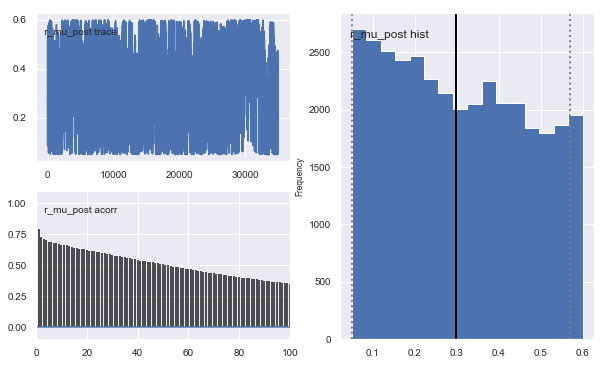

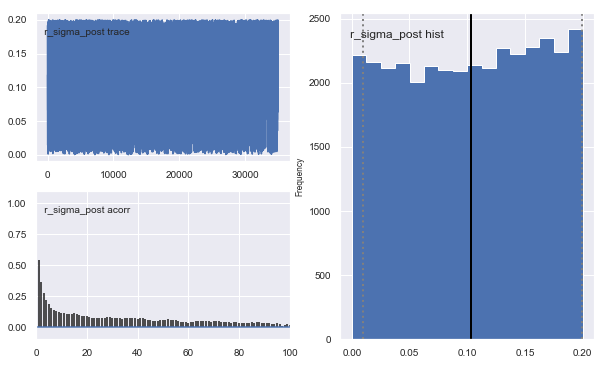

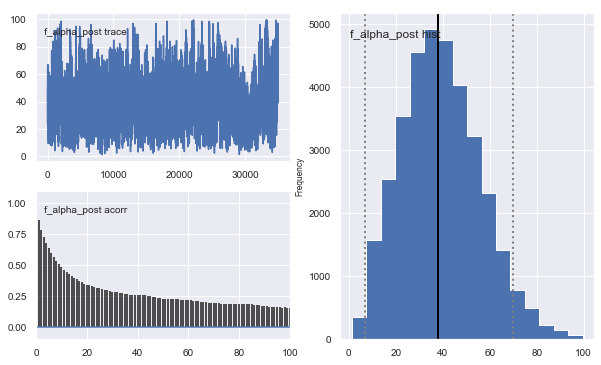

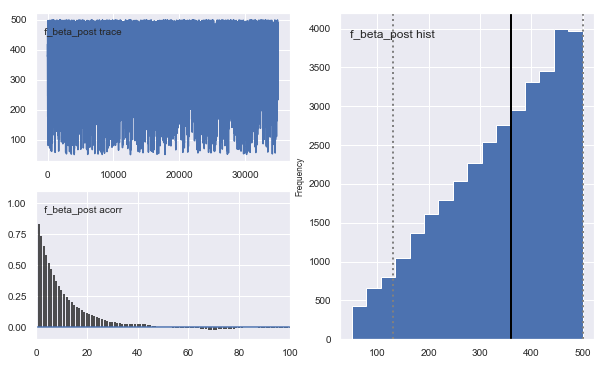

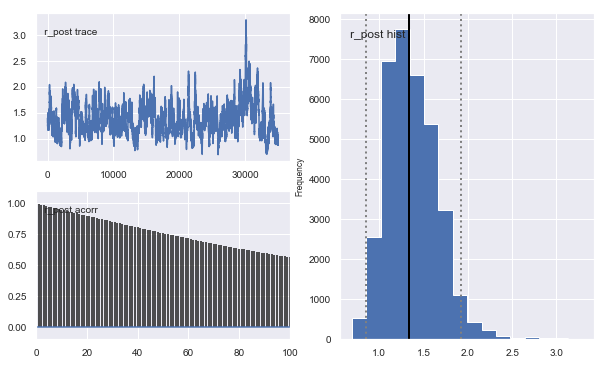

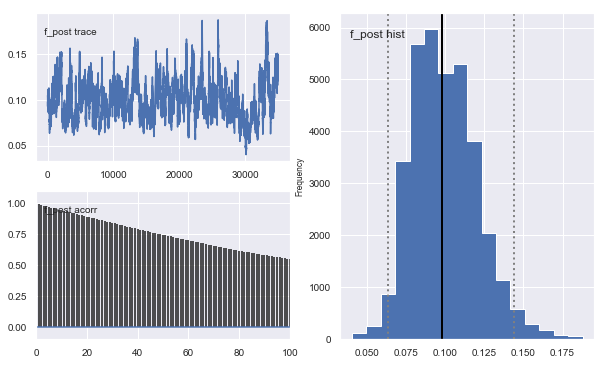

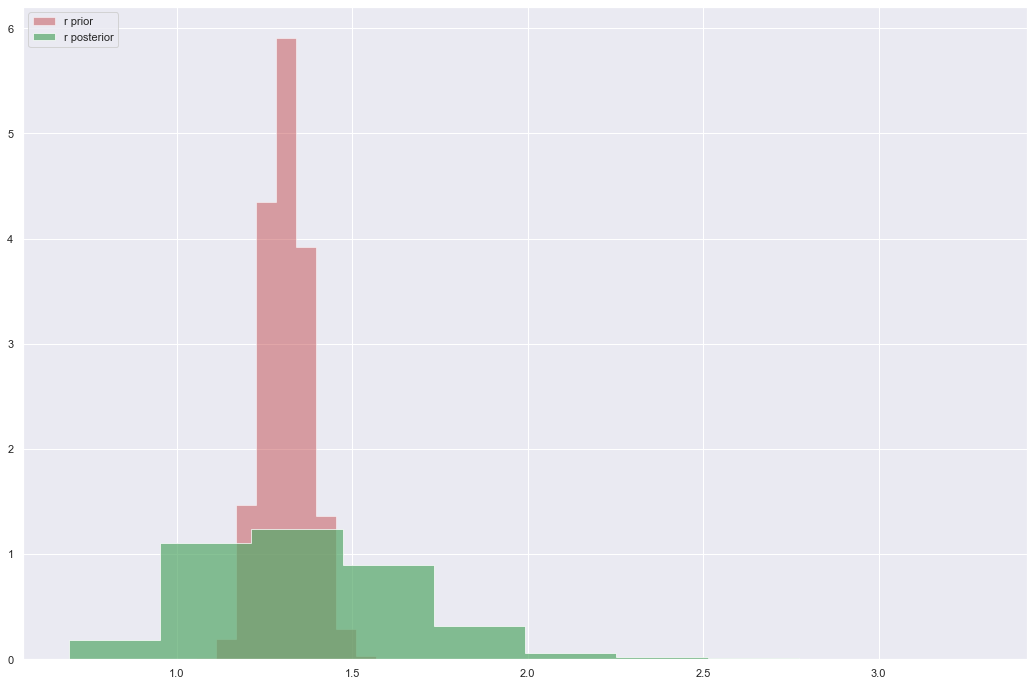

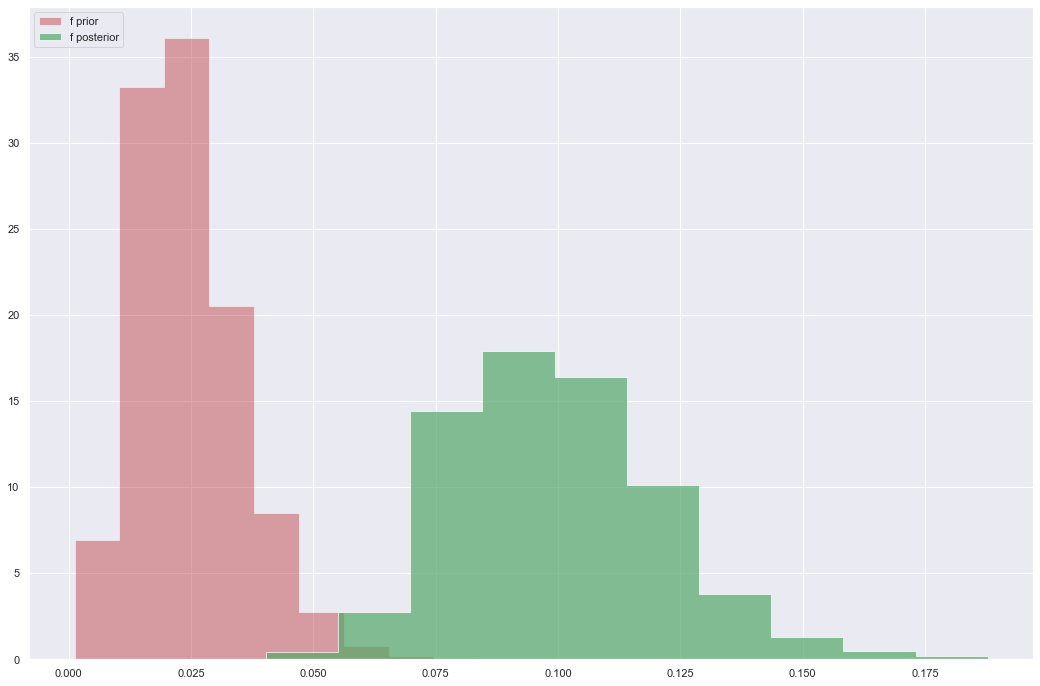

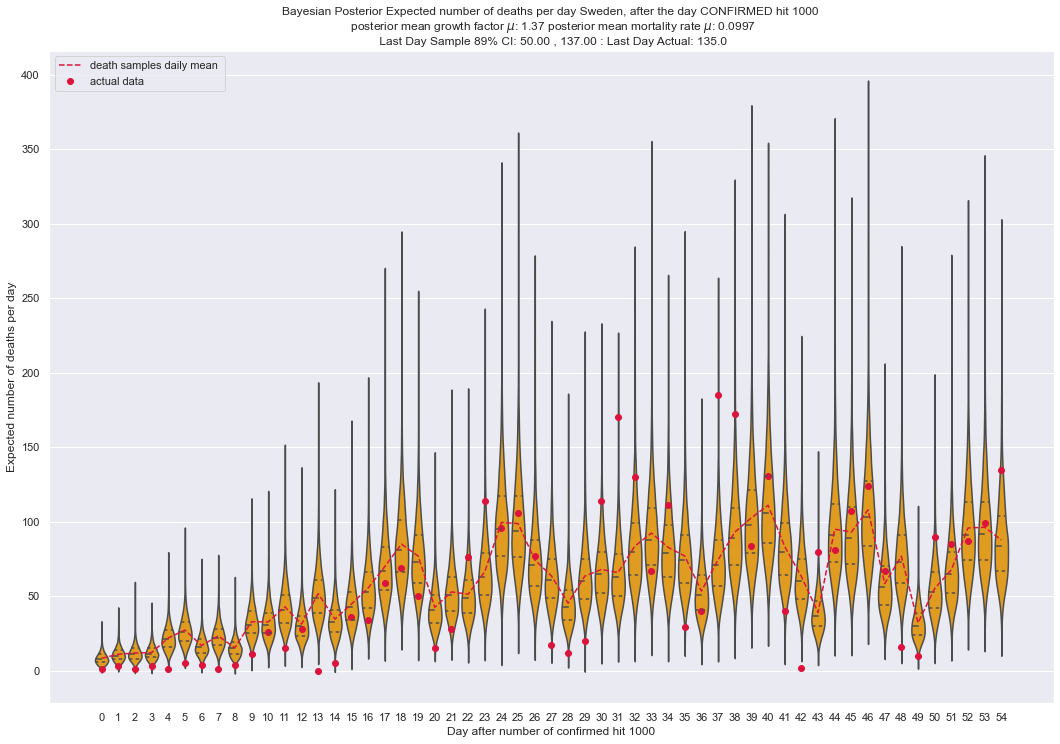

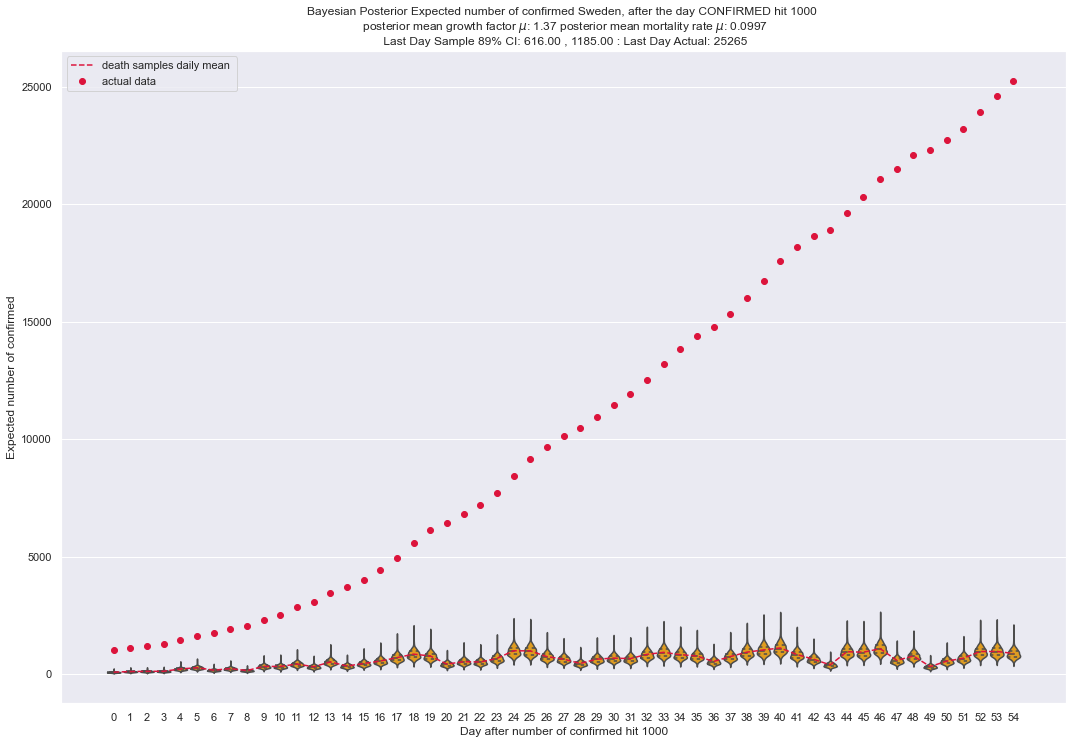

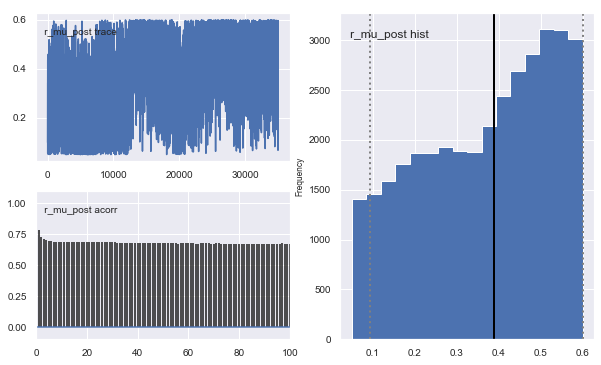

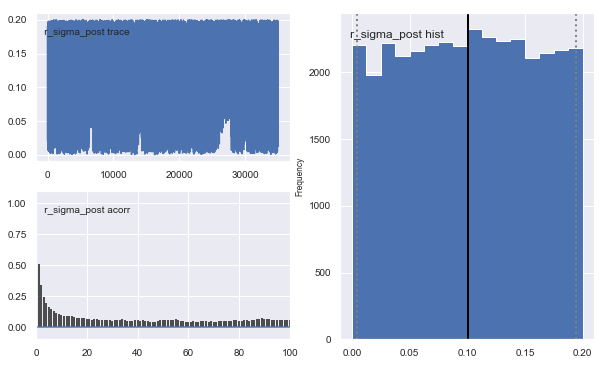

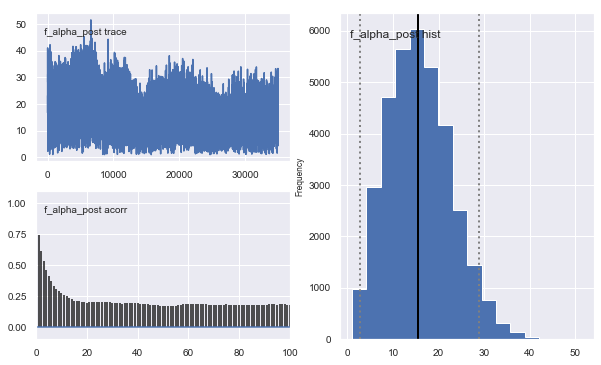

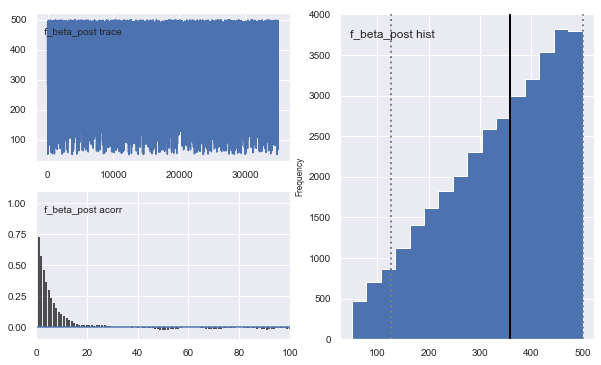

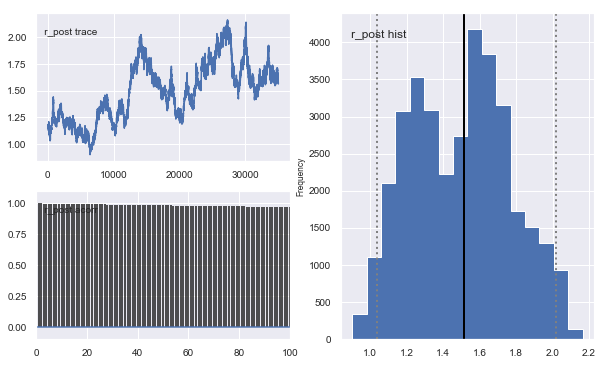

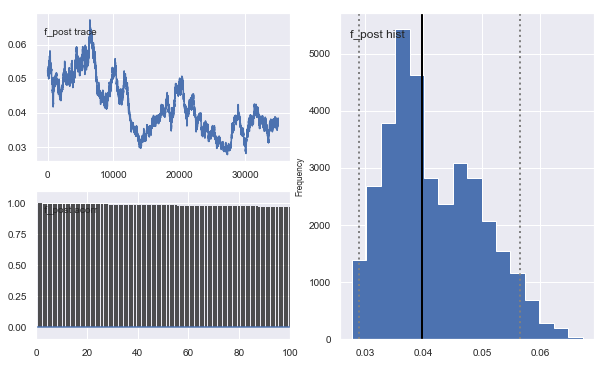

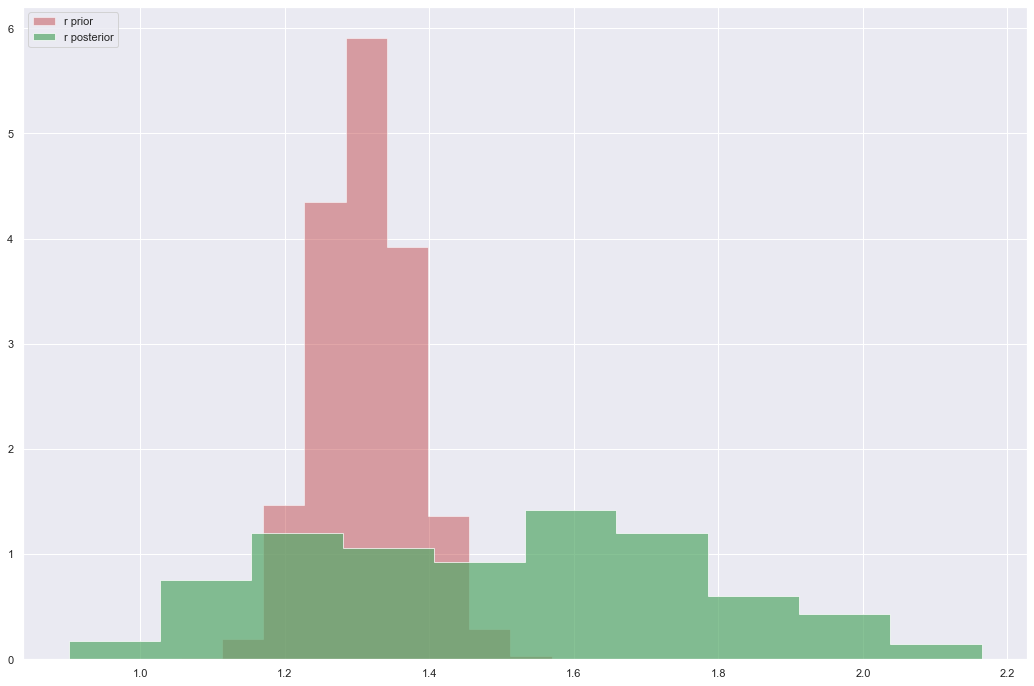

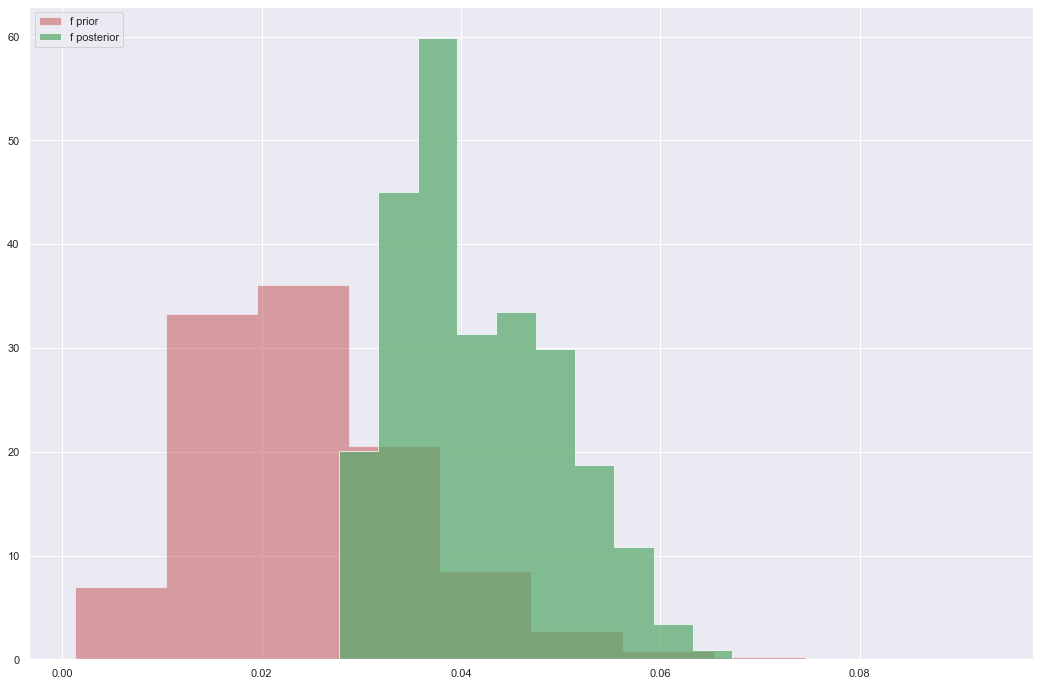

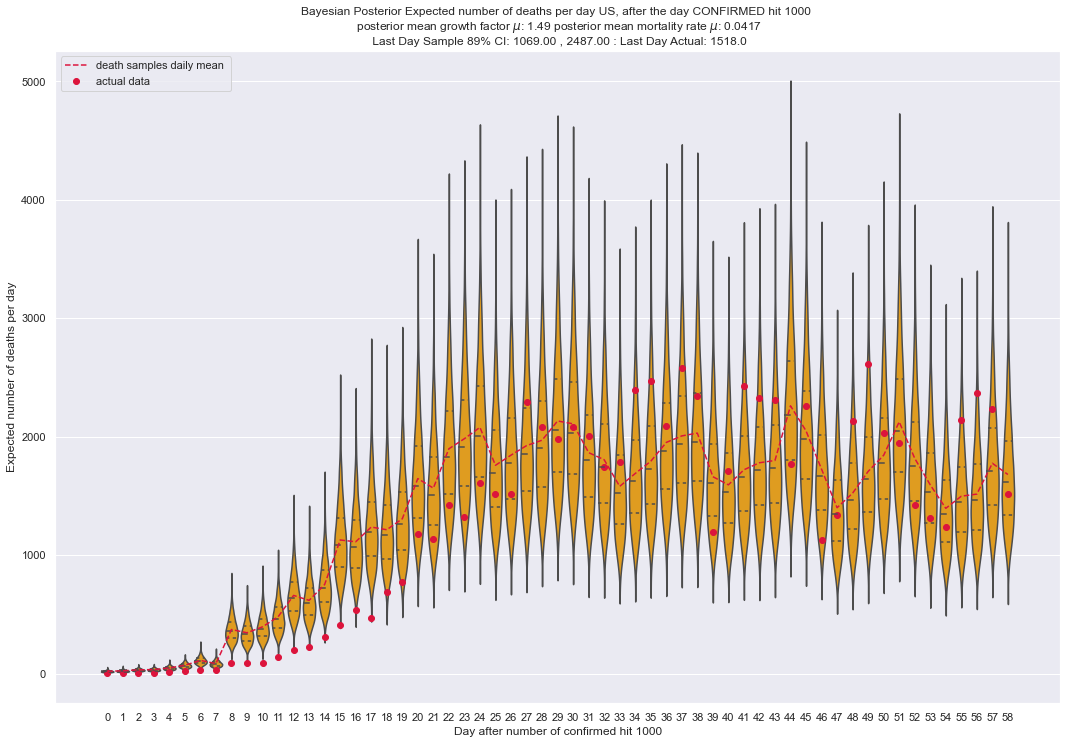

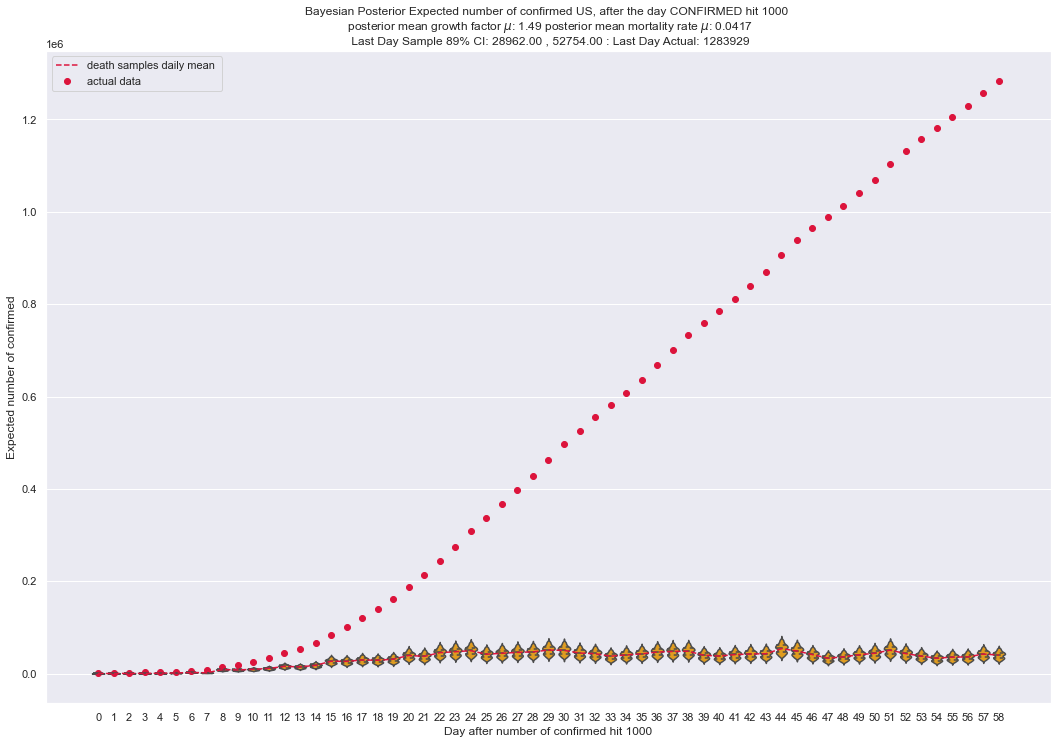

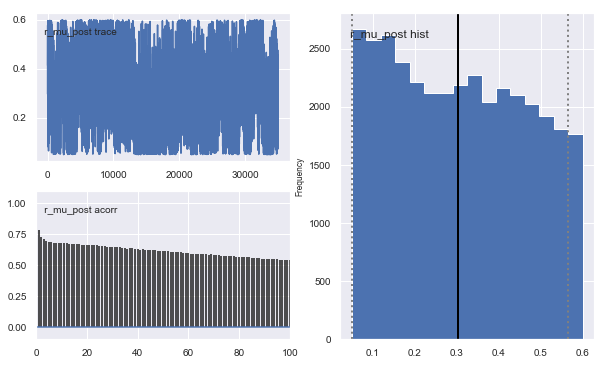

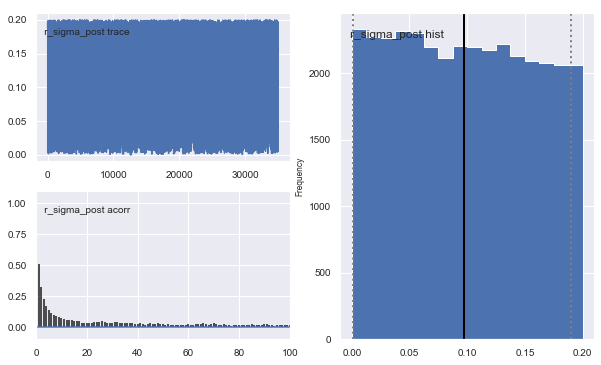

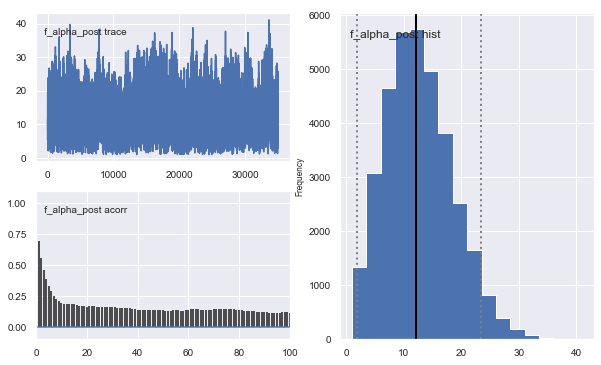

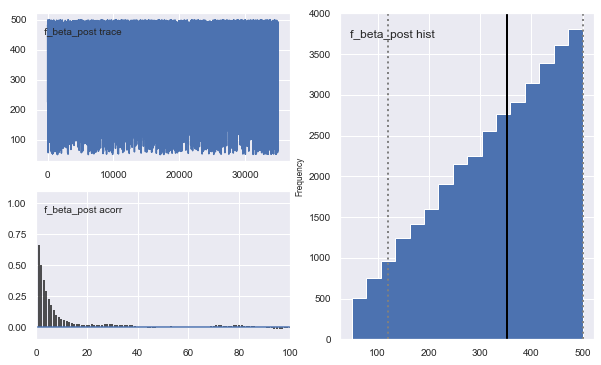

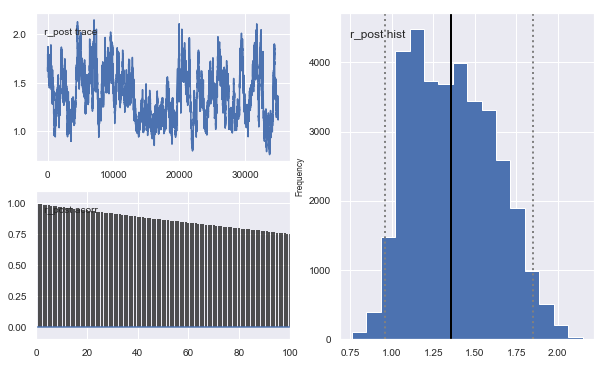

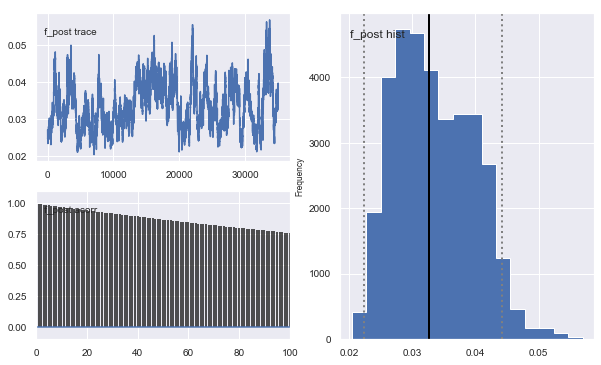

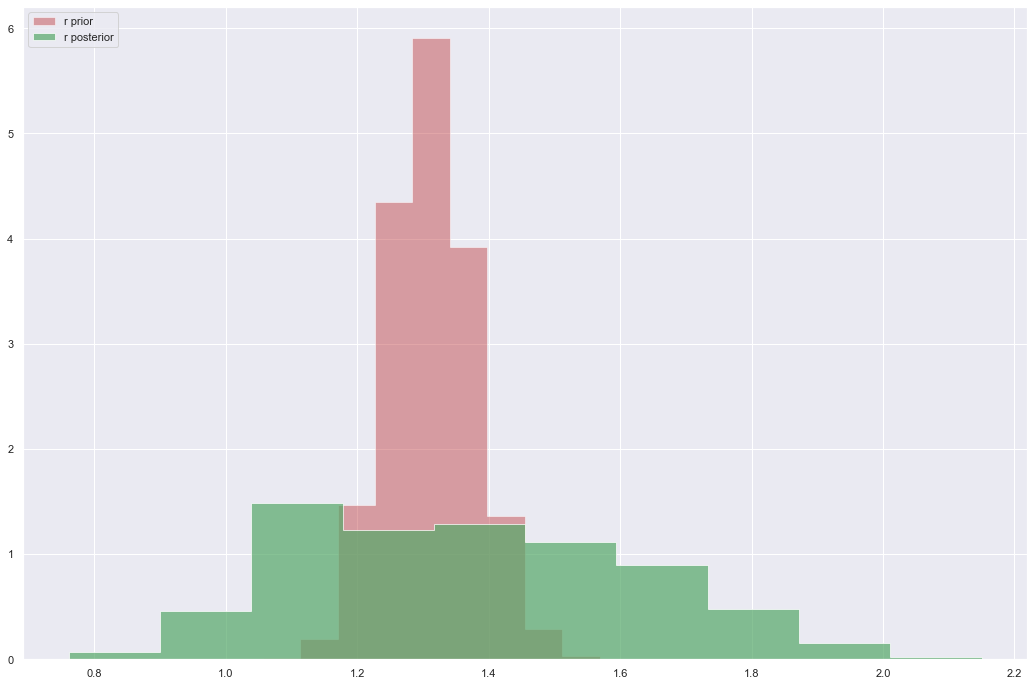

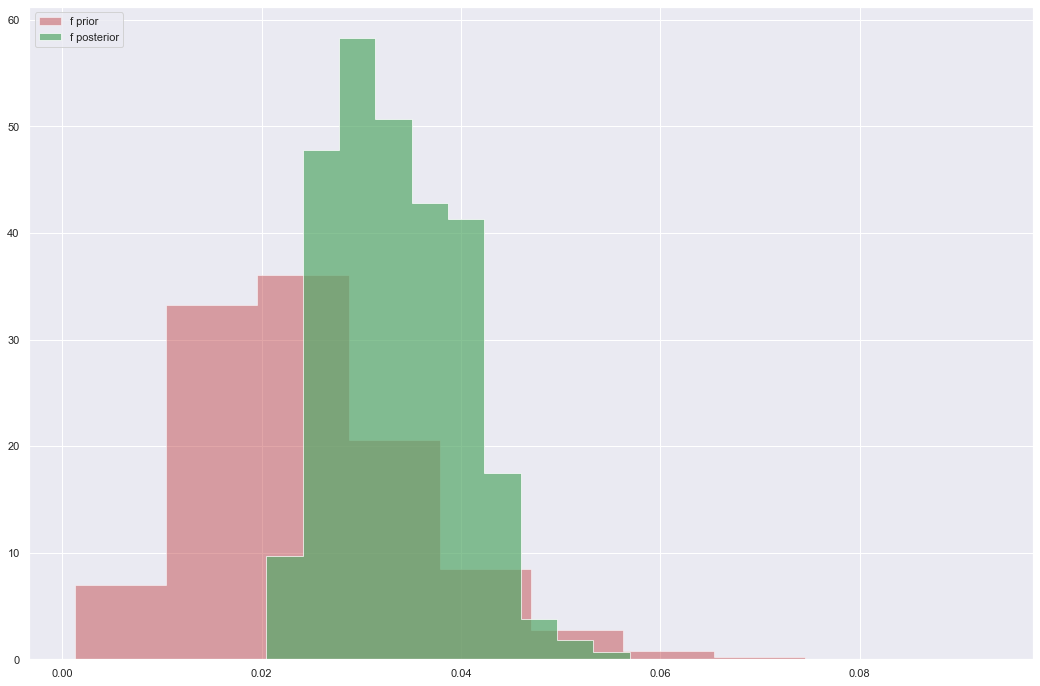

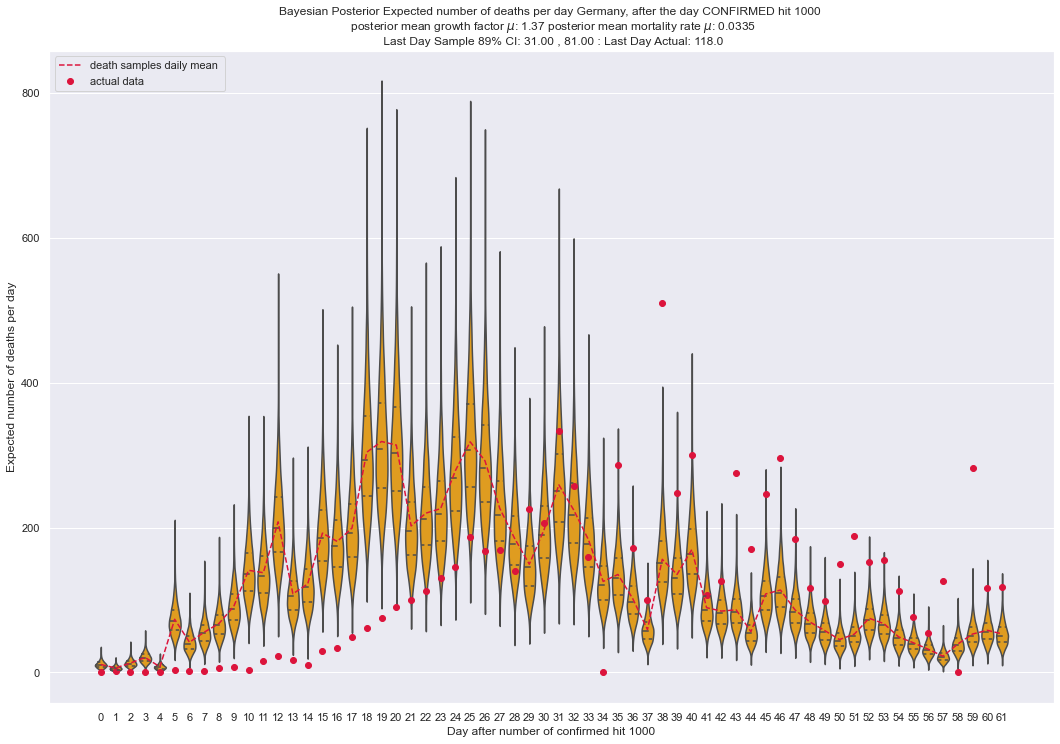

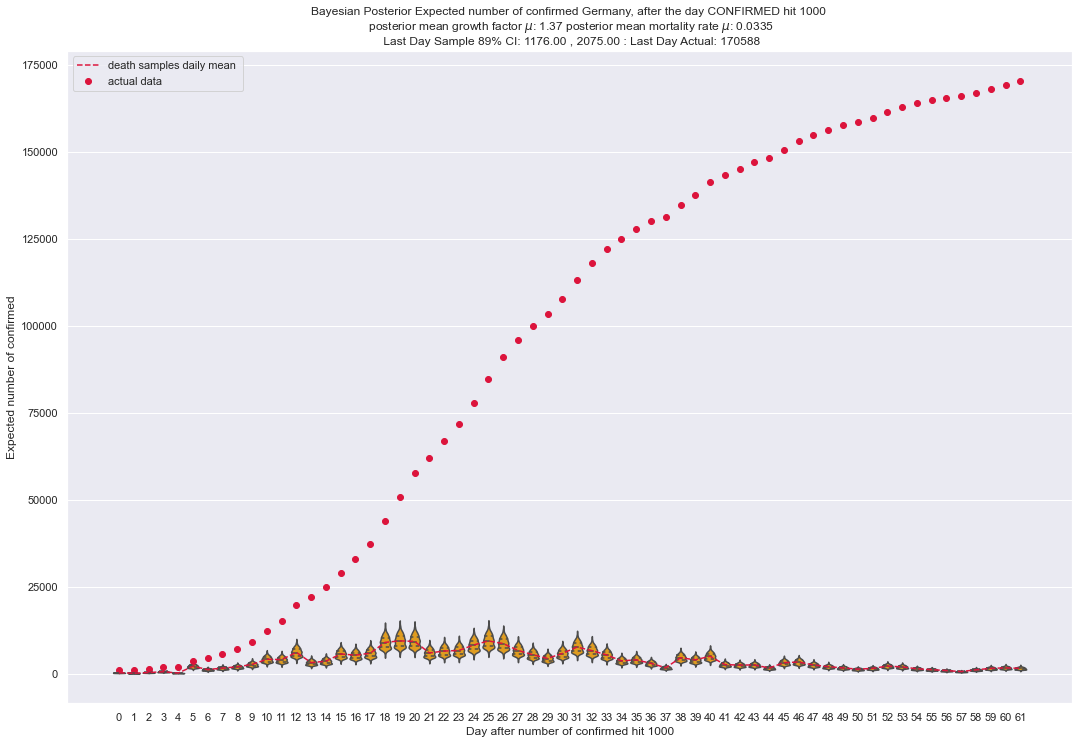

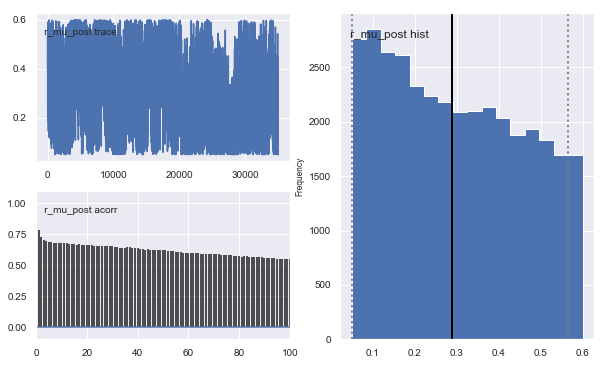

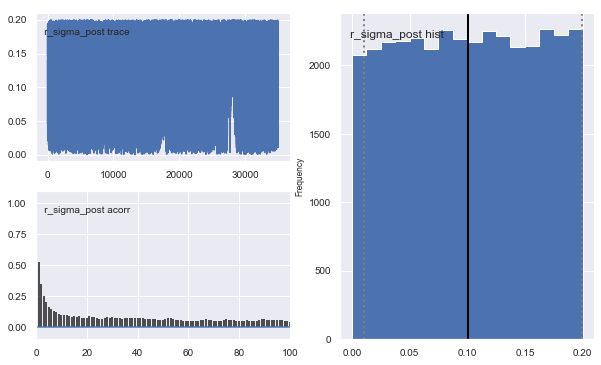

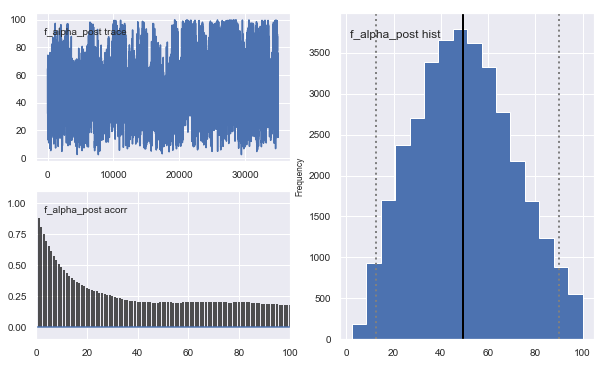

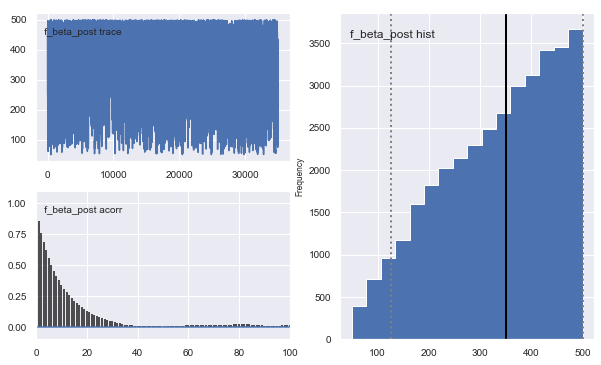

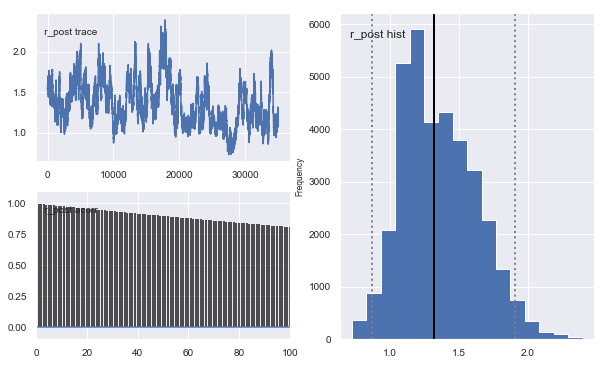

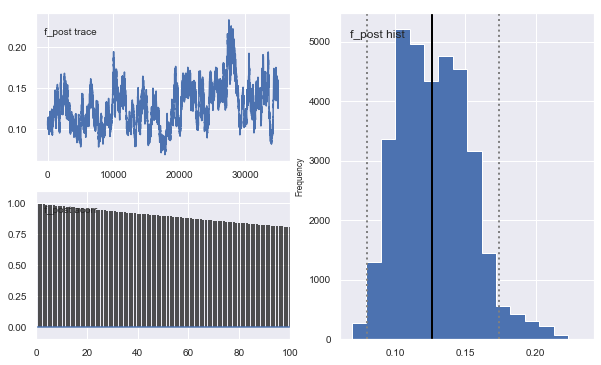

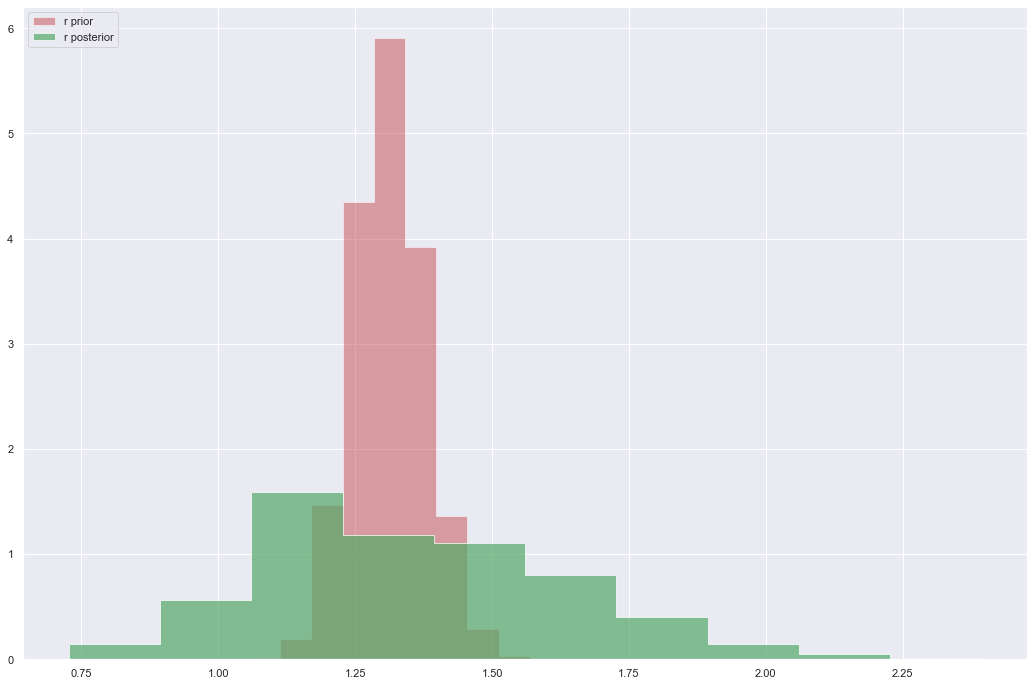

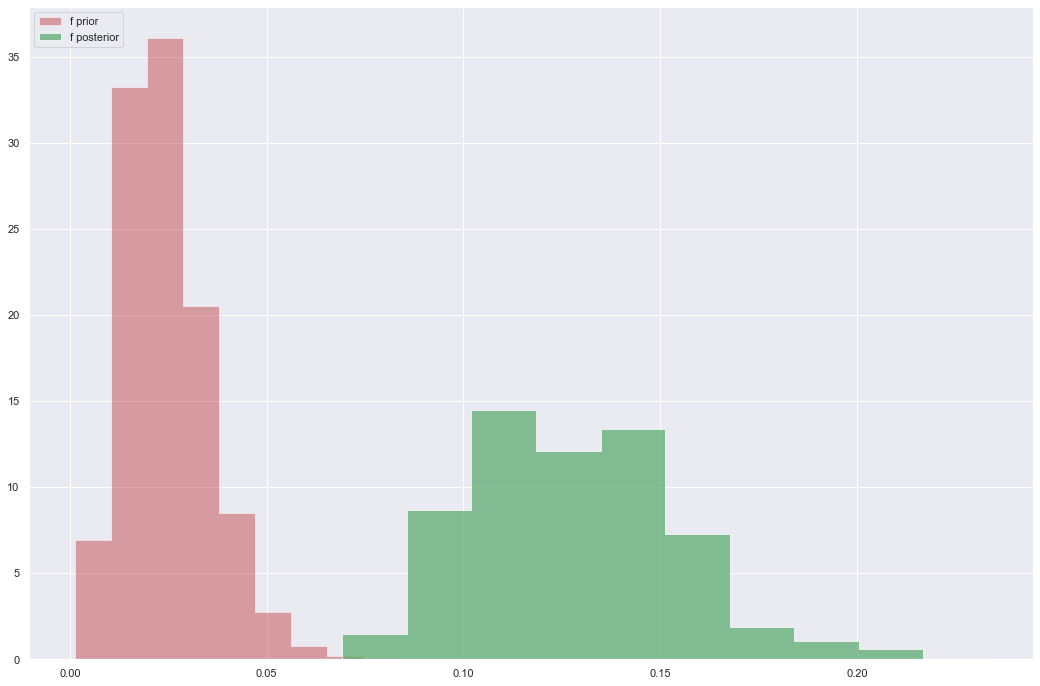

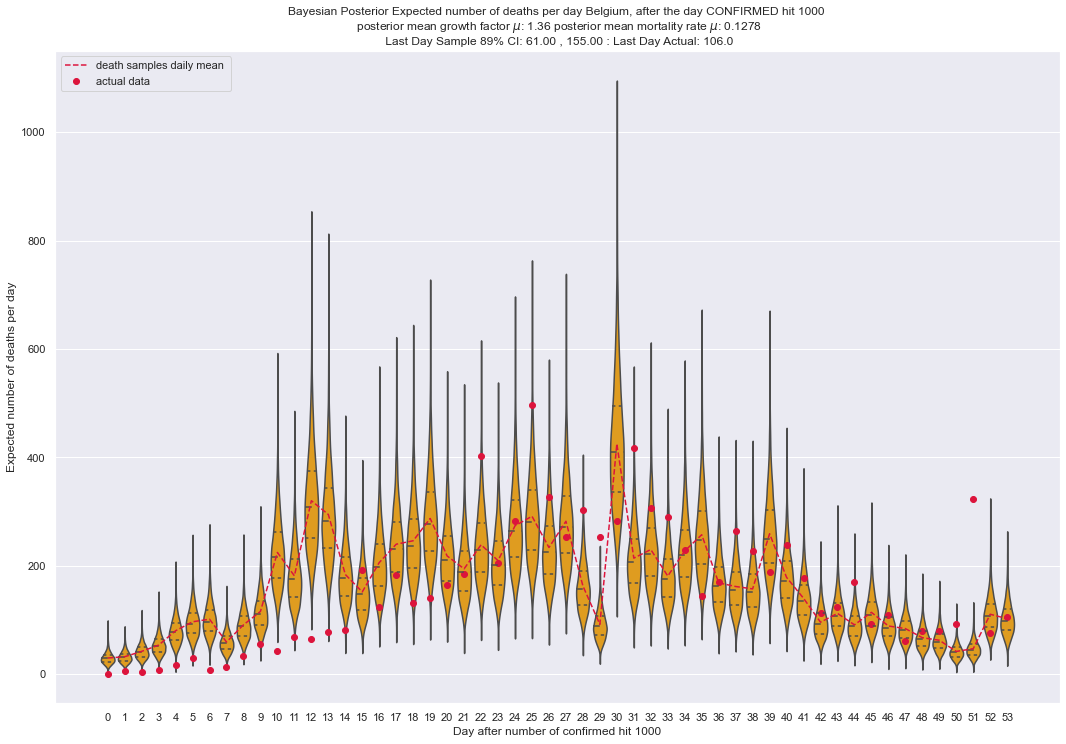

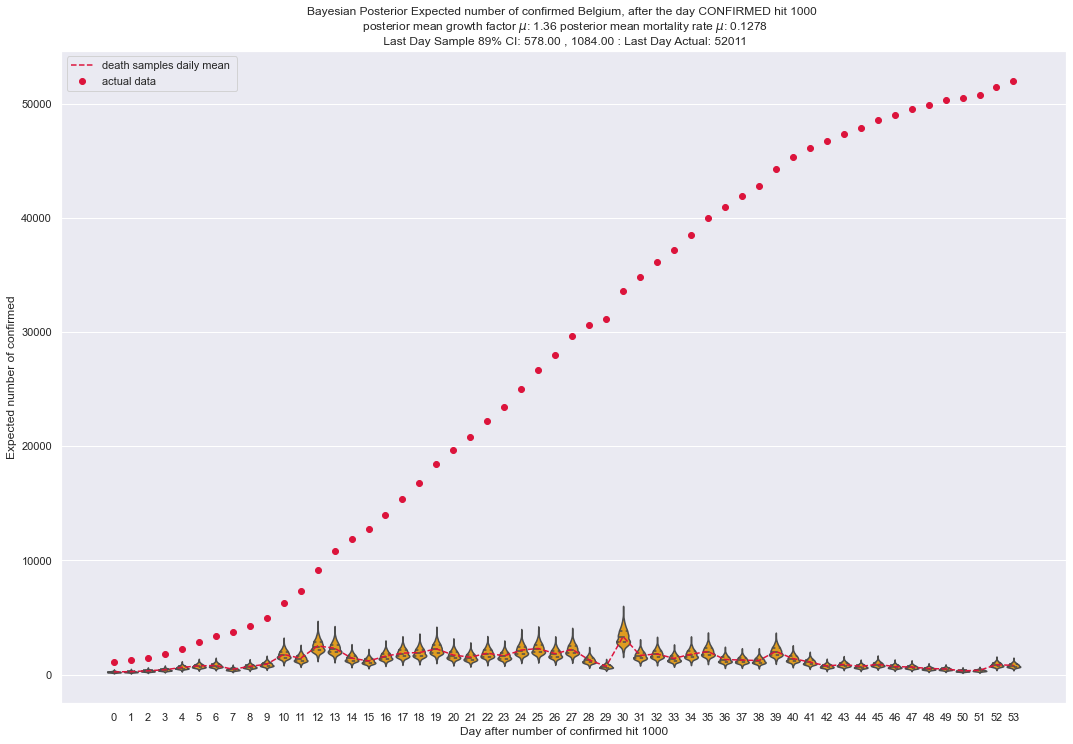

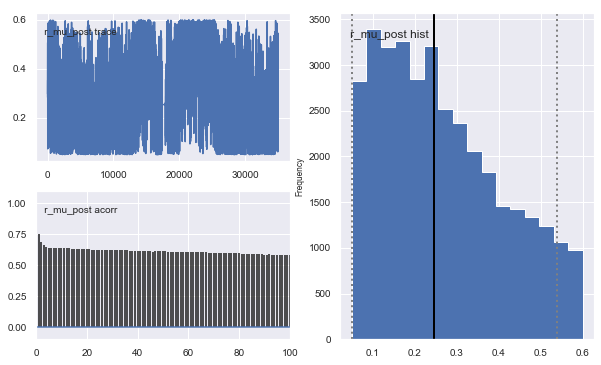

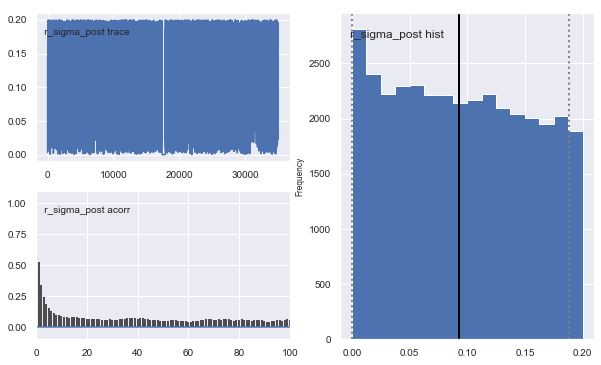

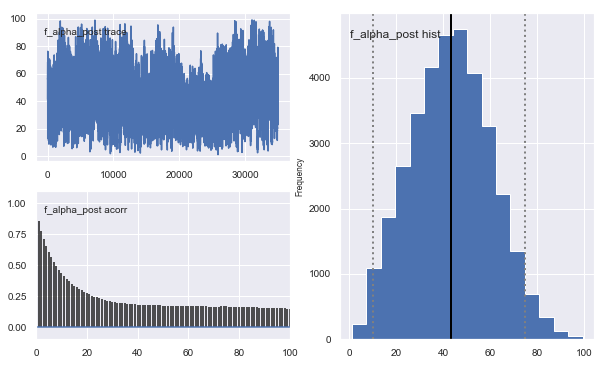

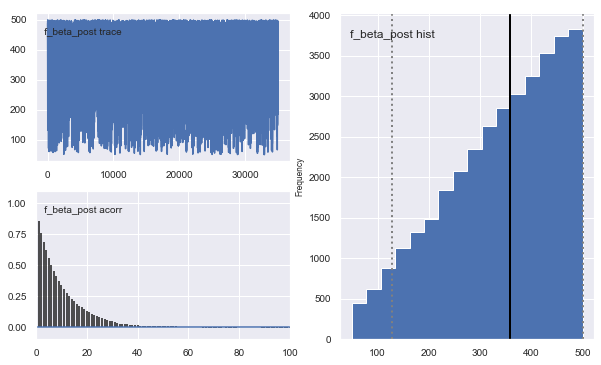

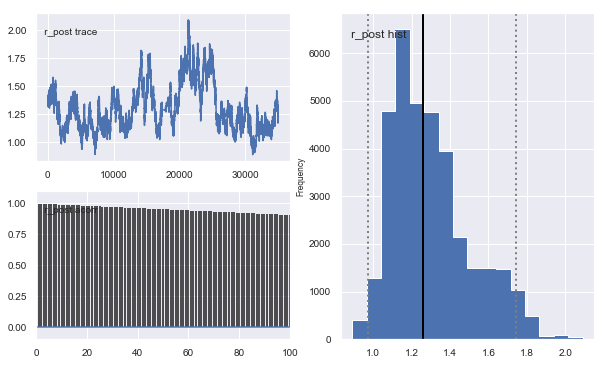

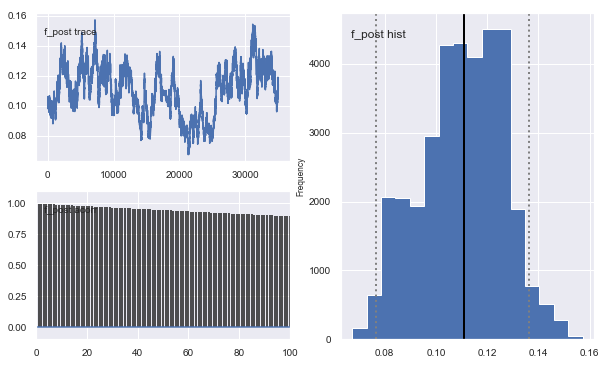

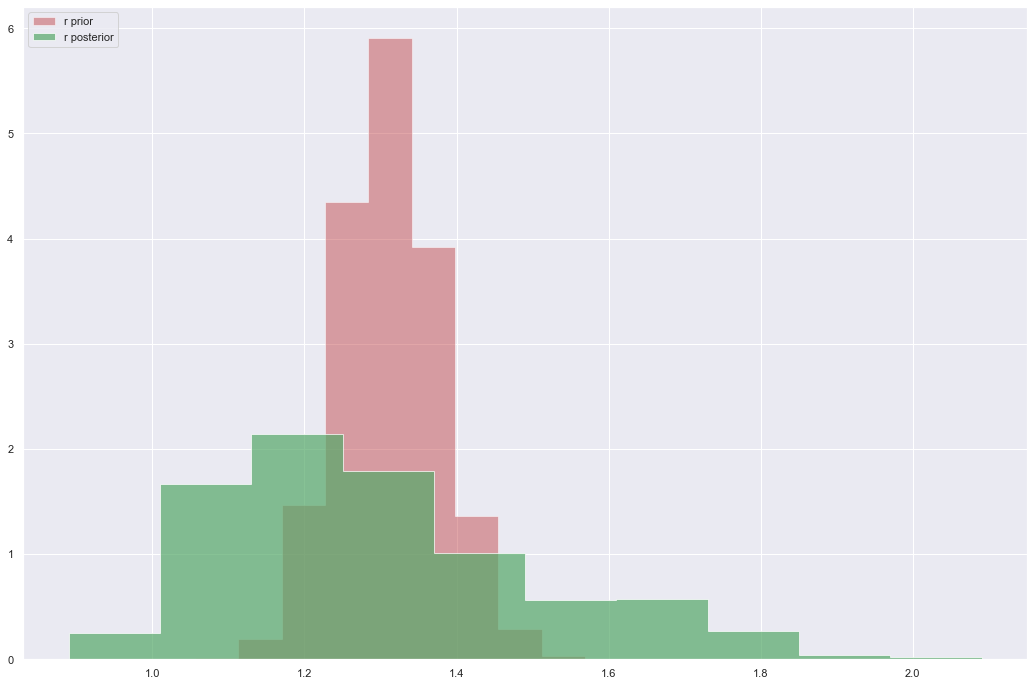

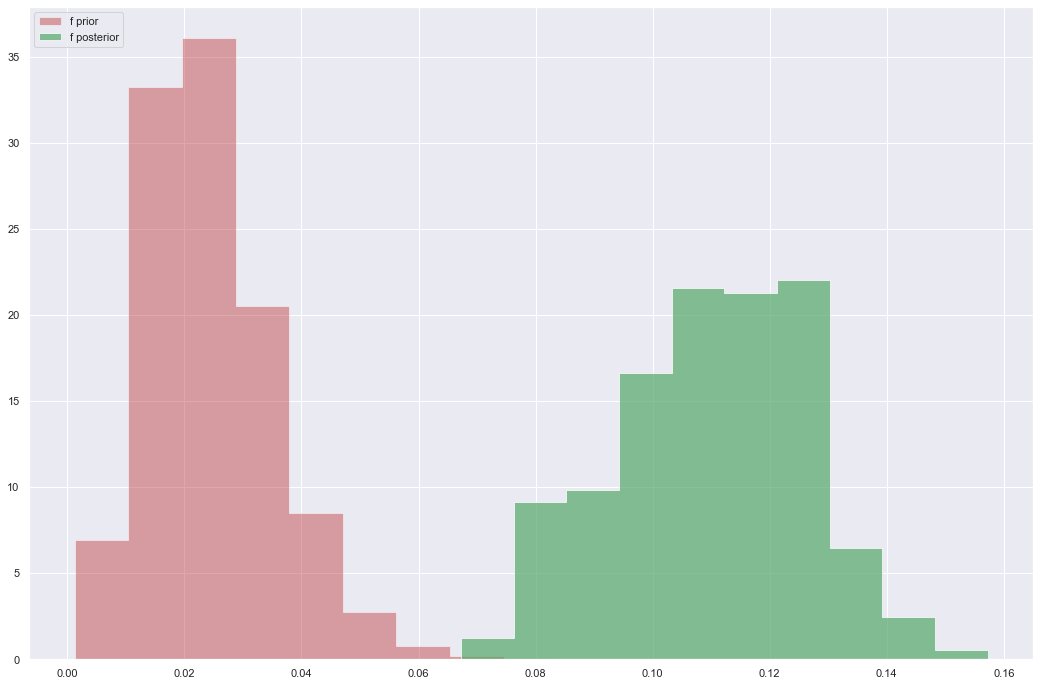

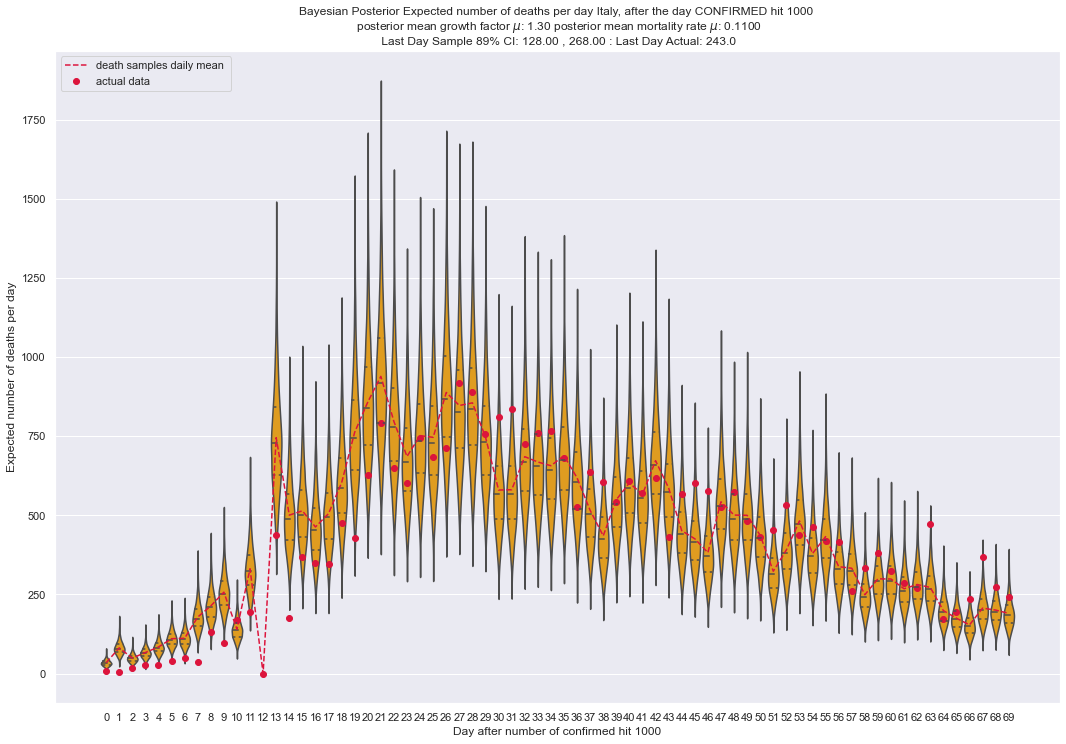

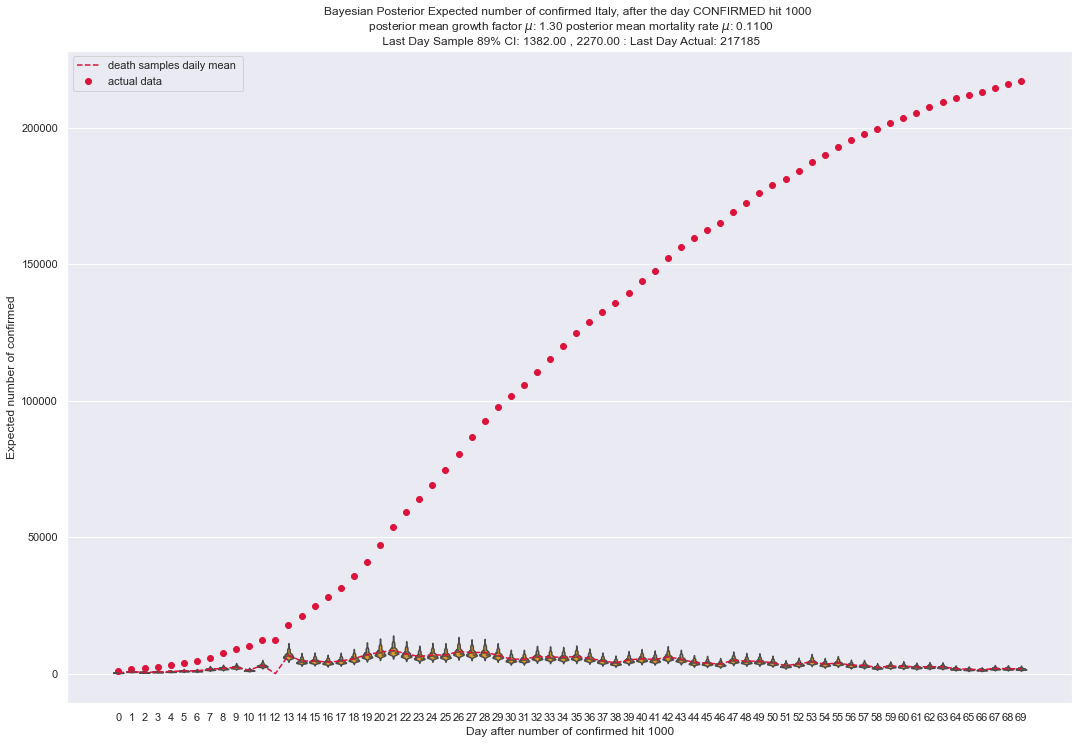

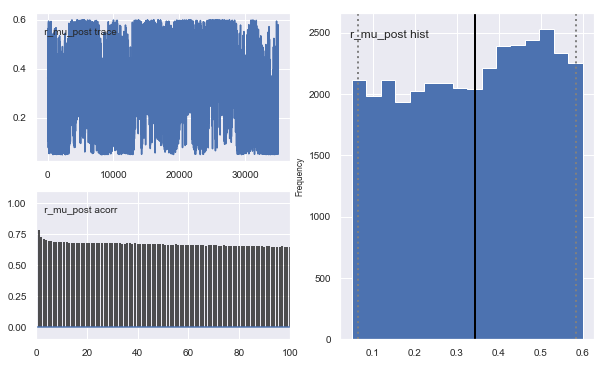

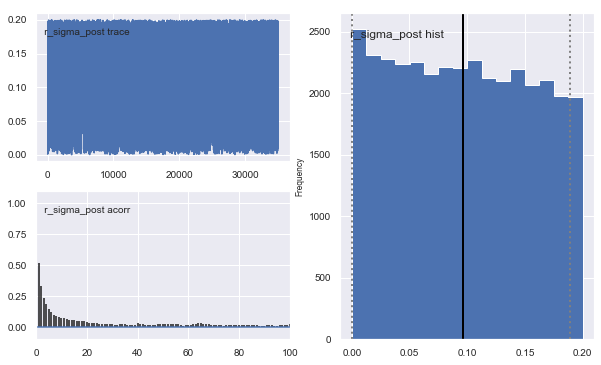

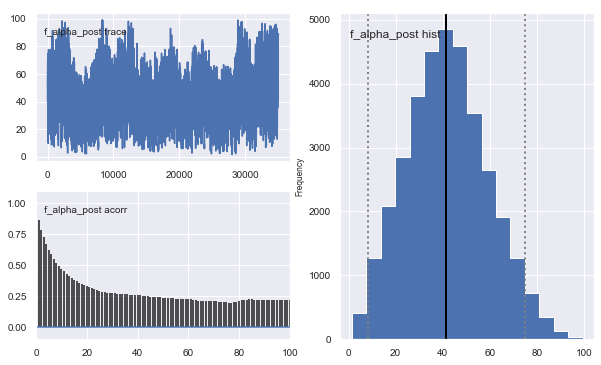

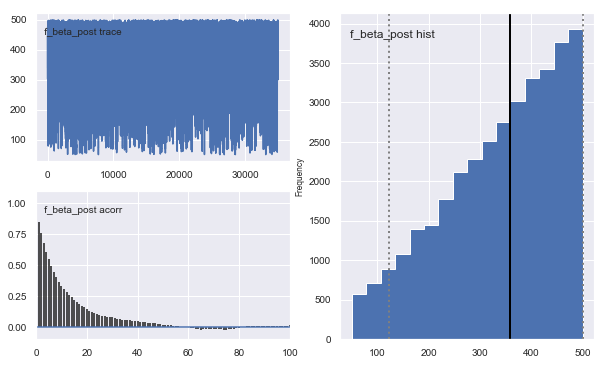

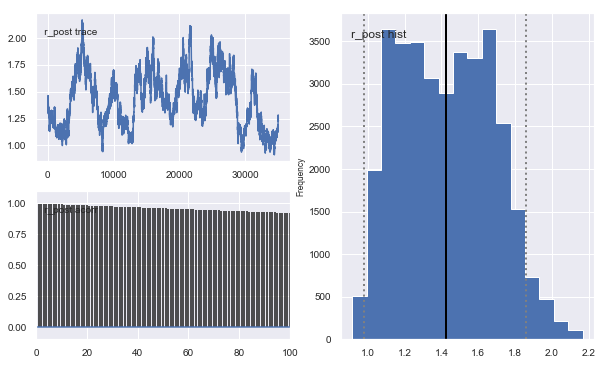

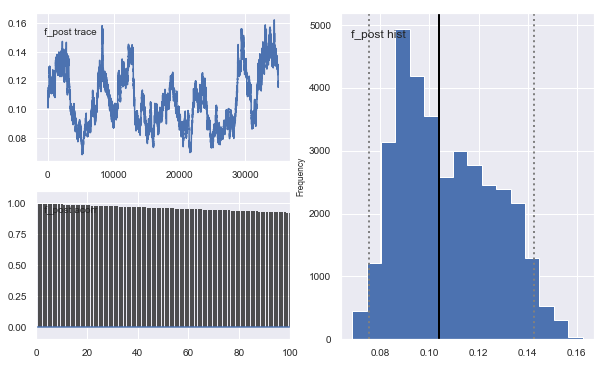

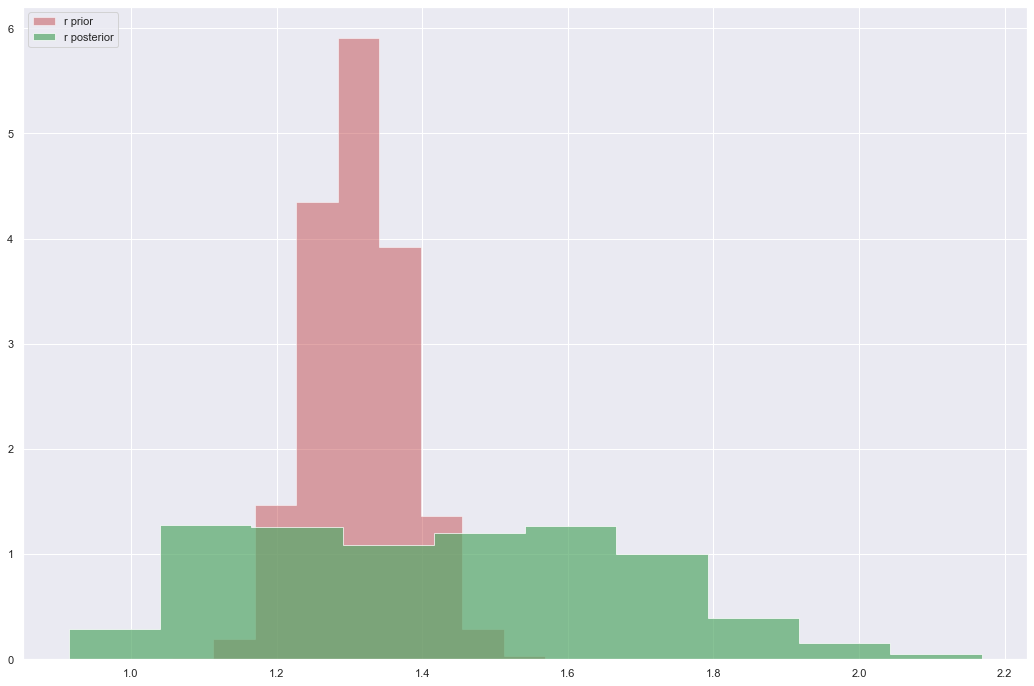

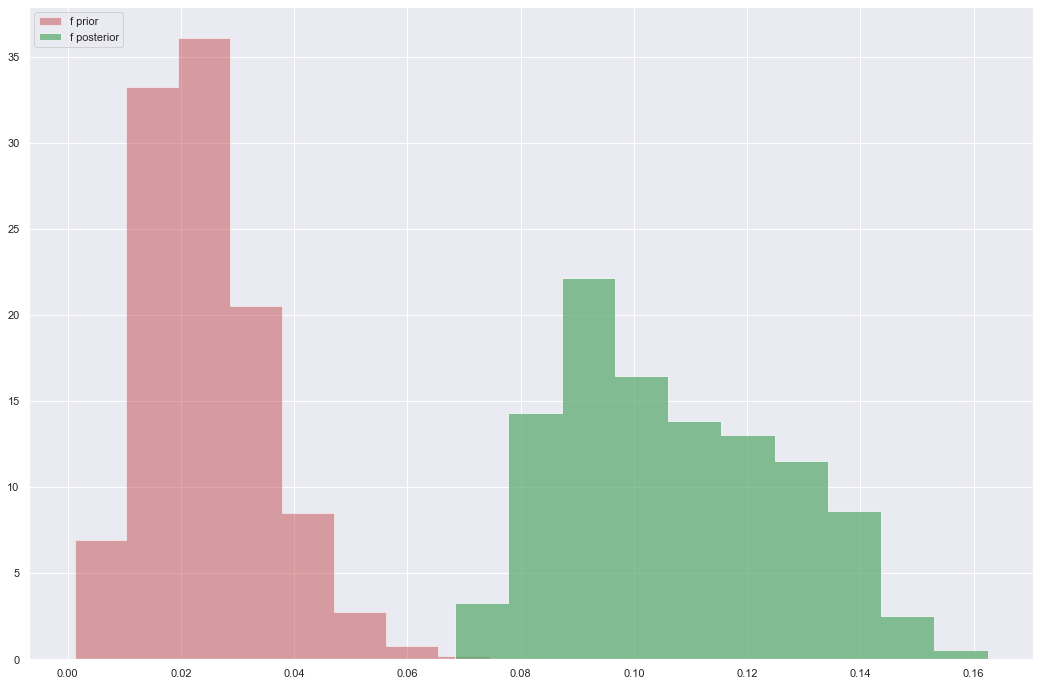

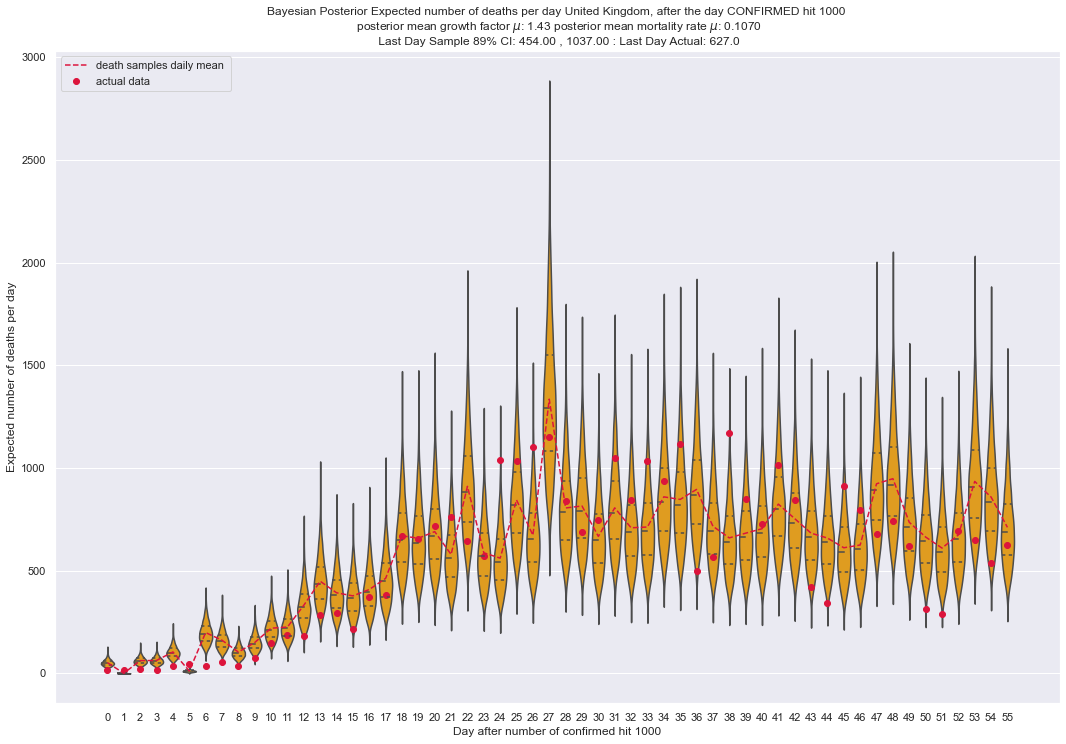

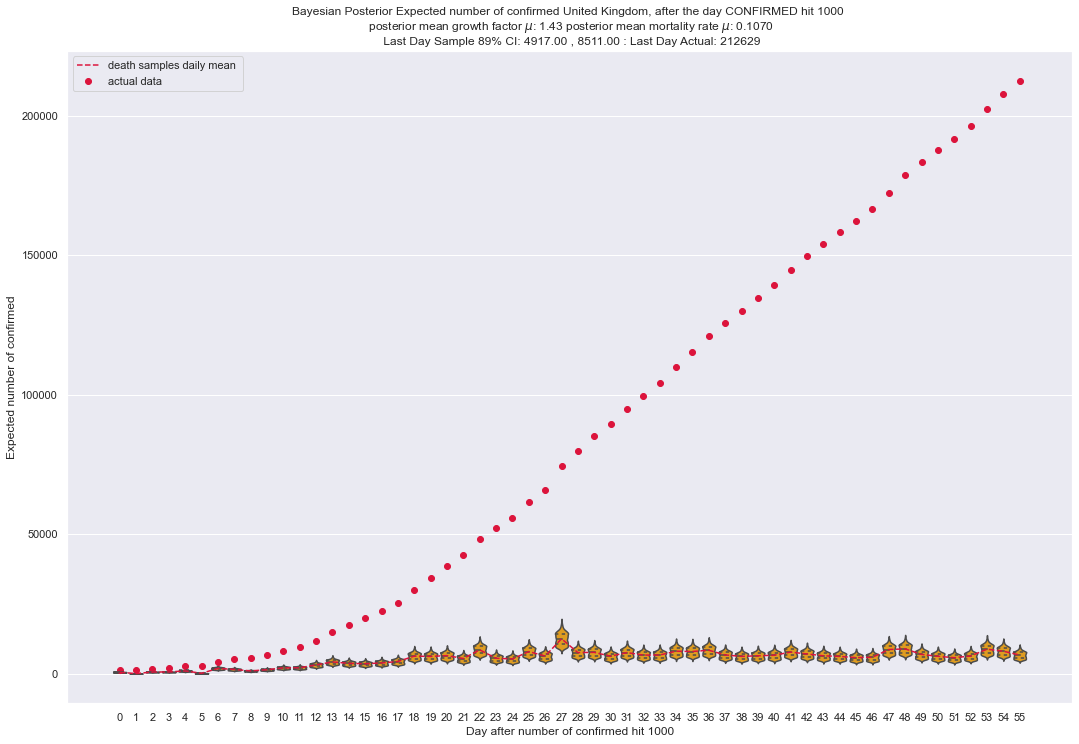

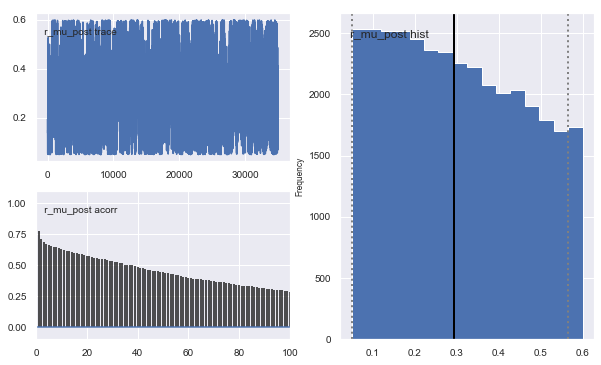

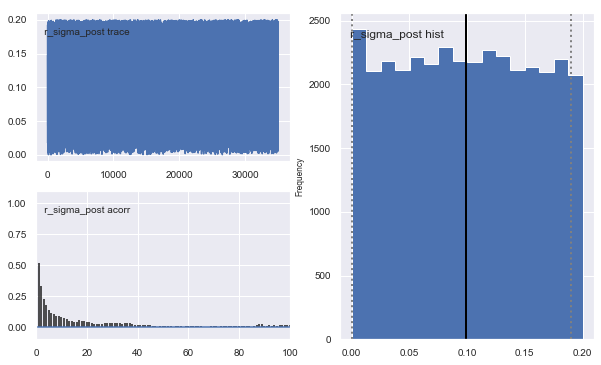

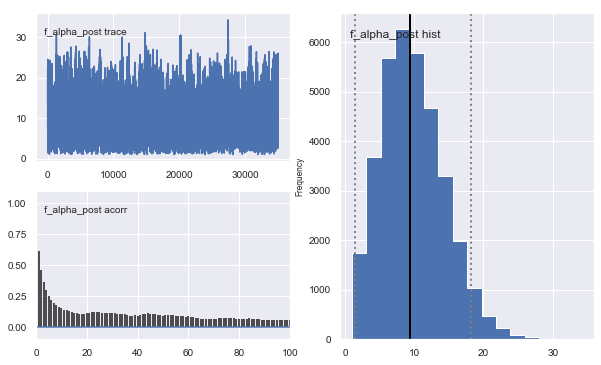

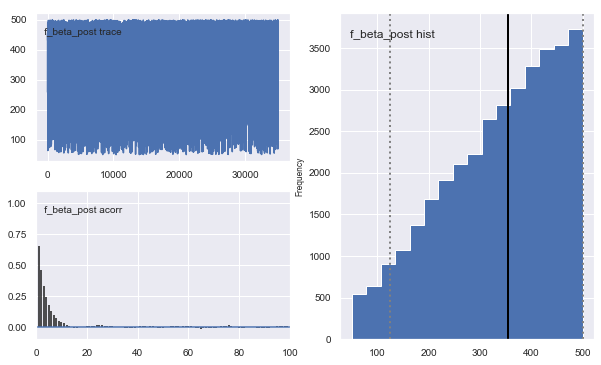

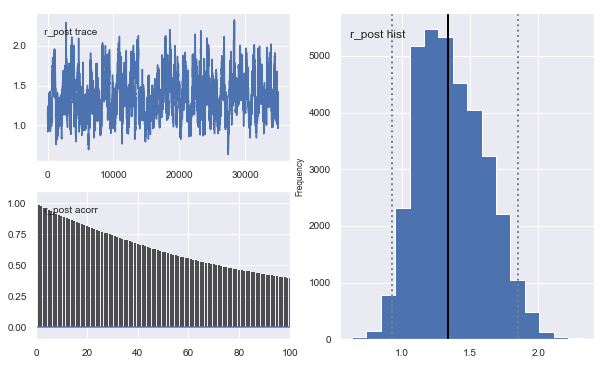

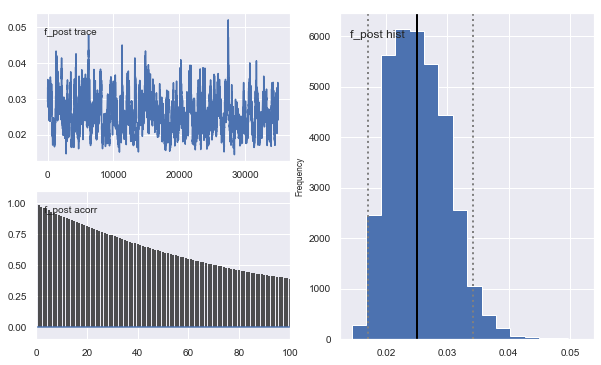

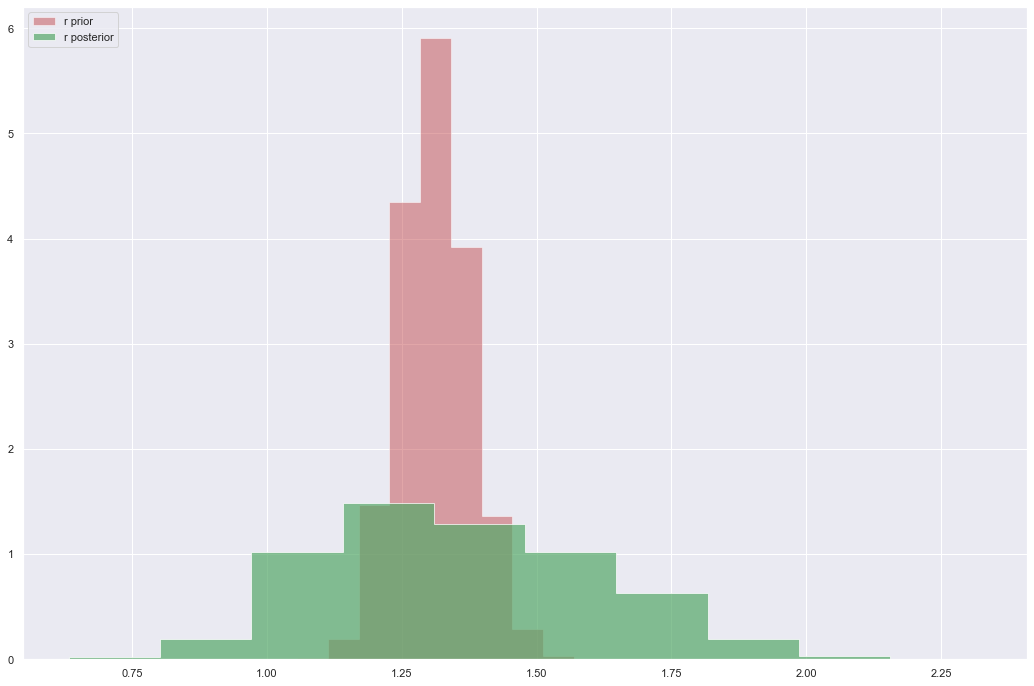

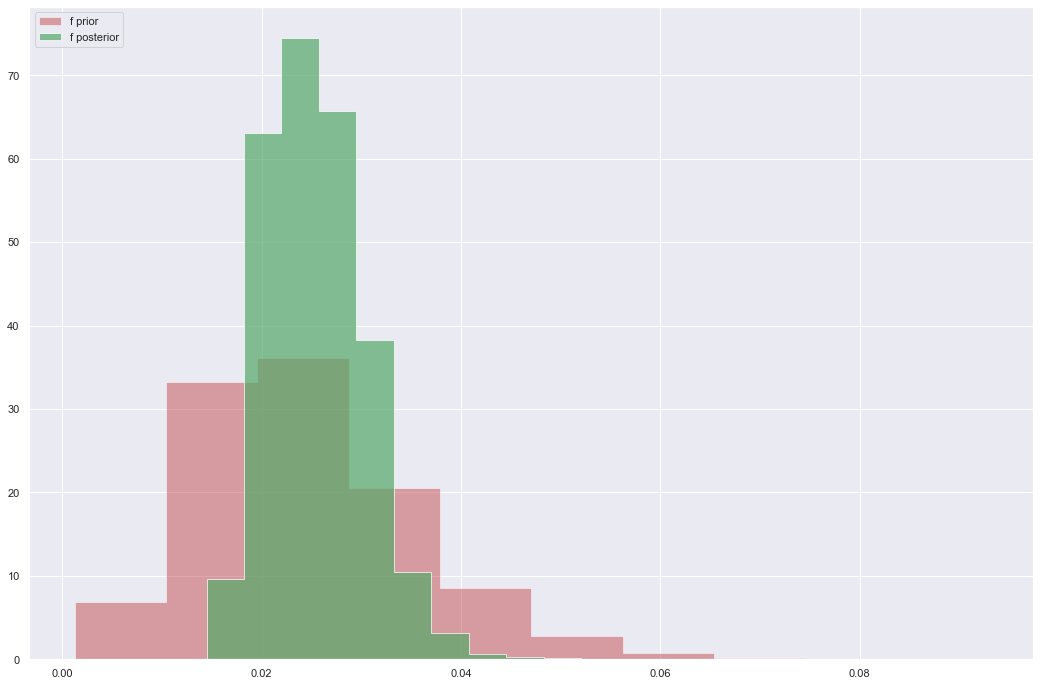

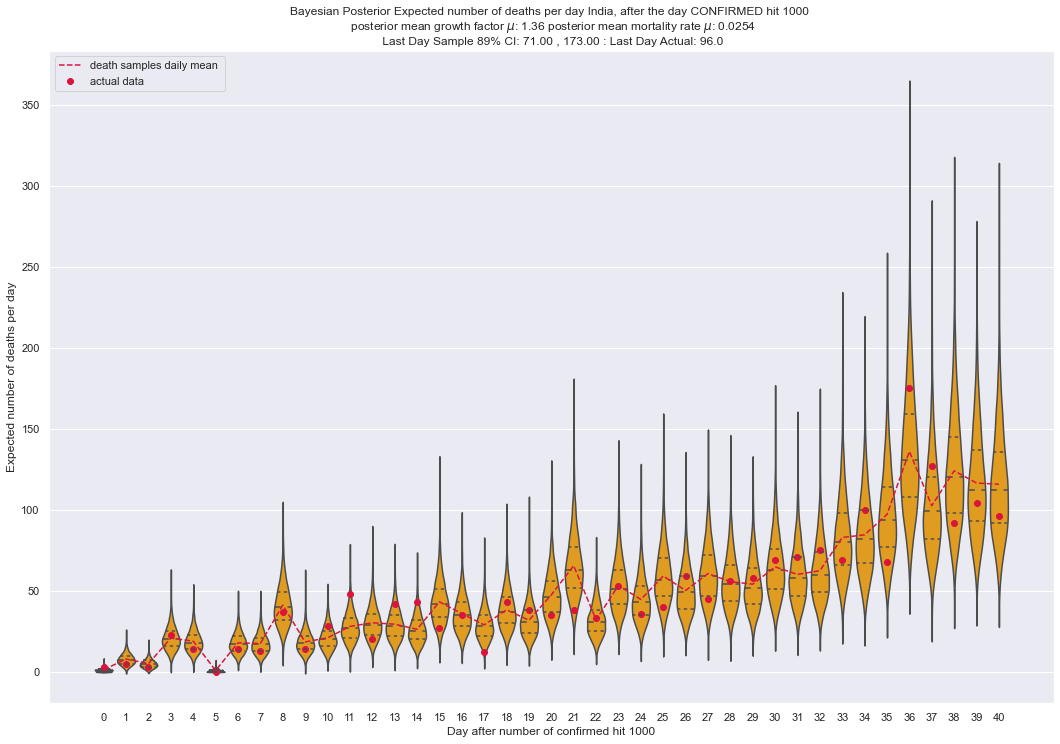

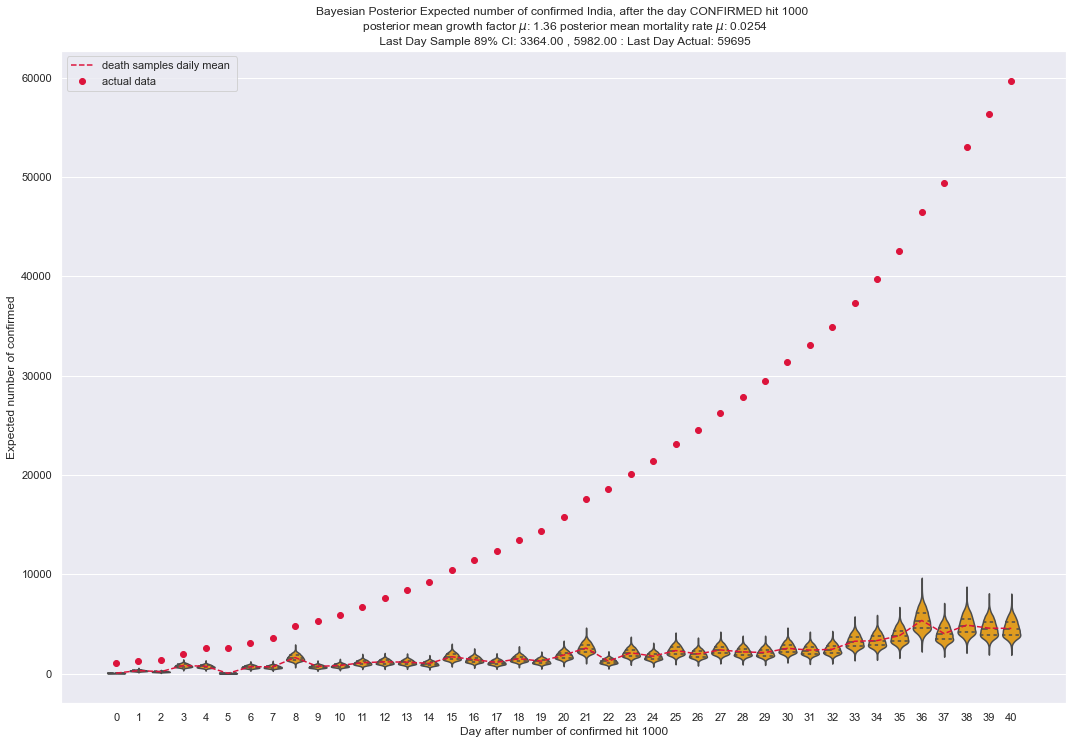

In [18]:
countries = ['Sweden','US','Germany','Belgium','Italy','United Kingdom','India','Spain']

#countries = ['United Kingdom','France','Austria','Turkey']
#countries = ['Netherlands','Belgium','France','Austria','United Kingdom']
#countries = ['Sweden']

for country_name in countries:
    
    df = process_country(country_name)

    limit = 1000
    mask = df['confirmed'] >= limit
    df = df[mask]

    #df = df[-10:]

    print ()
    print ('++++++++++++++++++++++ {} +++++++++++++++++++++++'.format(country_name))
    print (df.tail())

    D = df['dead_inc']
    #C = df['confirmed'] # this is the original param used, trying inc below
    C = df['inc'] # basing on inc gives more truthful picture of when growth has slowed down
    
    result = inference(df,C,D,country_name)
    sample_df,conf_sample_df = create_posterior_samples(result)
    
    print ('sample_df()')
    print (sample_df.tail(40))
    print ('daily death mean samples')
    print (sample_df.mean(axis=1).tail(40))
    print ('Last day summary stats')
    sample_df.iloc[-1].describe()
    
    print ('conf sample_df.tail(40)')
    print (conf_sample_df.tail(40))
    print ('conf sample daily mean')
    print (conf_sample_df.mean(axis=1))
    
    plot(result,df,sample_df,country_name)
    plot(result,df,conf_sample_df,country_name,'confirmed','confirmed')
    result.to_pickle('violin_daily_result_{}.pkl'.format(country_name.replace(' ','_')))

In [ ]:
#plot(result,df,sample_df,country_name)


In [ ]:
US = pd.read_pickle('us_state_dict.pkl')

In [ ]:
ny = US['New York']
ny = ny[['confirmed','deceased','recovered','inc','factor','dead_inc','dead_factor']]
ny

In [ ]:
print (ny)

D = ny['dead_inc']
#C = ny['confirmed']
C = ny['inc']

country_name='New York'
result = inference(ny,C,D,'New York')
result.to_pickle('violin_daily_result_{}.pkl'.format(country_name.replace(' ','_')))
sample_df,conf_sample_df = create_posterior_samples(result)
plot(result,ny,sample_df,'New York')
plot(result,ny,conf_sample_df,'New York','confirmed','confirmed')